# Analyse Exploratoire du jeu de Données `OpenFoodFacts`
*Les liens ne fonctionnent pas lorsque le notebook est affiché sur **Github**. Donc vous souhaitez visualiser ce notebook en ligne avec les liens menu actifs, vous pouvez le faire à cette adresse: https://nbviewer.org/github/Valkea/OC_AI_03/blob/main/Cleaning_Nutrigrade.ipynb )*

* [1. Objectif du projet](#P01)
* [2. Présentation générale du jeu de données](#P02)
* [3. Préselection des colonnes utiles](#P03)
* [4. Nettoyage du jeu de données](#P04)
    * [Suppression des doublons](#clean_duplicates)
    * [Suppression des valeurs aberrantes](#clean_outliers)
    * [Corrélations linéaires](#clean_correlations)
    * [Imputations des valeurs manquantes](#clean_imputations)
* [5. Démarche méthodologique d’analyse de données](#P05)
    * [Analyses univariées](#analysis_univariate)
    * [Analyses multivariées](#analysis_multivariate)
* [6. Nettoyage des données](#P06)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

# Objectif  <a class="anchor" id="P01"></a>

Le Nutri-grade est une information qui peut être utile pour comparer divers produits d'une même catégorie les uns avec les autres. Cependant, tous les produits ne disposent pas de cette information et il pourrait être intéressant de pouvoir calculer ce grade à partir des indications disponibles sur les étiquettes des produits (ou même simplement en scannant le code-barre).

**Nous allons donc essayer de calculer le nutri-grade en nous basant sur les données disponibles sur l'étiquette d'un produit.**

En cherchant sur le site https://www.santepubliquefrance.fr on peut trouver des [informations](https://www.santepubliquefrance.fr/content/download/150262/file/QR_scientifique_technique_310322.pdf) *(page 30)* nous permettant de déterminer les éléments favorables ou défavorables au calcul de ce grade.

#### Éléments défavorables au score

- Apport calorique pour cent grammes.
- Teneur en sucre.
- Teneur en graisses saturées.
- Teneur en sel.

#### Éléments favorables au score

- Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive.
- Teneur en fibres.
- Teneur en protéines.

#### Précisions utiles

- Pour calculer la teneur de fruits et légumes, les féculents (tel que pomme de terre, patate douce, taro, manioc et tapioca) ne sont pas pris en compte.
- Pour les fromages, la teneur en protéines est toujours prise en compte car celle-ci est liée à celle en calcium. Ceci améliore le nutri-score des fromages et la cohérence entre celui-ci et les recommandations nutritionnelles du Haut Conseil de la Santé Publique. Celles-ci recommandent en effet de consommer des produits laitiers plusieurs fois par jour. 

# 2. Présentation générale du jeu de données <a class="anchor" id="P02"></a>

Le [jeu de données](https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv) utilisé dans le cadre de l'appel à projets de l'agence *Santé publique France* qui consiste à rendre les données de santé plus accessibles, est une liste de 2.251.894 produits alimentaires répertoriés par les volontaires de l'association [Open Food Facts](https://world.openfoodfacts.org).

Chacun des produits référencé est décrit par un certain nombre de caractèristiques nutritionels *(taux de graisse, de sucre, de sel, de fibres, de protéines, de vitamines, etc.)* et par des méta-données *(code-barre, nom du produit, catégorie, lieu de production, date d'ajout dans la DB, auteur de l'ajout, etc.)*.

> Le jeu de données complet fait plus de 5.9GB. Et il est difficile de travailler avec un tel volume de donnée,<br> donc **nous avons crée un jeu de données réduit (dans Cleaning_01.ipynb) que nous allons utiliser ici**.

#### Commençons par charger les colonnes (et leur dtype) sélectionnées dans le premier notebook

In [2]:
filename = 'data/dtypes_low.csv'

In [3]:
dtypes_df = pd.read_csv(filename, sep=',', index_col=0)

In [4]:
cols_to_keep = dtypes_df.columns
dtypes = dtypes_df.to_dict('records')[0]

In [5]:
cols_to_keep

Index(['sugars_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'code', 'iron_100g', 'pnns_groups_2', 'energy_100g', 'cholesterol_100g',
       'saturated-fat_100g', 'additives_n', 'salt_100g', 'serving_quantity',
       'vitamin-a_100g', 'labels_tags', 'trans-fat_100g', 'vitamin-c_100g',
       'nutriscore_grade', 'product_name', 'states_tags', 'serving_size',
       'fiber_100g', 'calcium_100g', 'sodium_100g', 'url',
       'carbohydrates_100g', 'traces_tags', 'nova_group', 'proteins_100g',
       'pnns_groups_1', 'nutriscore_score', 'allergens', 'quantity',
       'additives_tags', 'ingredients_tags', 'main_category', 'fat_100g',
       'categories_tags'],
      dtype='object')

#### Puis chargeons le jeu de données réduit

In [6]:
filename = 'data/en.openfoodfacts.org.products.csv'

In [7]:
data = pd.read_csv(filename, sep='\t', dtype=dtypes, usecols=cols_to_keep)

### Explorons le jeu de données réduit

In [8]:
data.head(3)

code                                                url  \
0     00000000000000225  http://world-en.openfoodfacts.org/product/0000...   
1  00000000000003429145  http://world-en.openfoodfacts.org/product/0000...   
2         0000000000017  http://world-en.openfoodfacts.org/product/0000...   

       product_name quantity categories_tags labels_tags  \
0    jeunes pousses      NaN             NaN         NaN   
1           L.casei      NaN             NaN         NaN   
2  Vitória crackers      NaN             NaN         NaN   

                                    ingredients_tags allergens traces_tags  \
0                                                NaN       NaN         NaN   
1  en:semi-skimmed-milk,en:dairy,en:milk,es:azuca...       NaN         NaN   
2                                                NaN       NaN         NaN   

  serving_size  ...  sugars_100g  fiber_100g proteins_100g  salt_100g  \
0          NaN  ...          NaN         NaN           NaN        NaN   
1          NaN  ...          9.8         NaN           2.7        0.1   
2          NaN  ...         15.0         NaN           7.8        1.4   

  sodium_100g vitamin-a_100g vitamin-c_100g calcium_100g iron_100g  \
0         NaN            NaN            NaN          NaN       NaN   
1        0.04            NaN            NaN          NaN       NaN   
2        0.56            NaN            NaN          NaN       NaN   

  fruits-vegetables-nuts-estimate-from-ingredients_100g  
0                                                NaN     
1                                                0.0     
2                                                NaN     

[3 rows x 36 columns]

> En voyant tous les `NaN` ci-dessus *(et retroactivement pour faciliter les analyses, car ils ne tons pas tous comptés comme None)*, nous allons remplacer les valeurs neutres par des `None` dans les colonnes numériques.

#### Remplaçons les diverses instances de types NaN ou équivalents dans les colonnes numériques par None

In [9]:
fill_rate_before = data.notnull().mean(axis=0)

In [10]:
for cat in data.select_dtypes(exclude=np.number).columns:
    data[cat].replace(['unknown',np.NaN, "NaN"], None, inplace=True)

In [11]:
fill_rate_after = data.notnull().mean(axis=0)

In [12]:
col_size = 15
print(f"{'COLONNE'.rjust(55)} | {'REMPLISSAGE AVANT'.center(col_size)} | {'REMPLISSAGE APRES'.center(col_size)} | {'DIFF'.center(11)}\n{'-'*111}")
for n, f1, f2 in zip(fill_rate_before.index, fill_rate_before, fill_rate_after):
    print(f"{n.rjust(55)} | {100.0*f1:16.2f}% | {100.0*f2:16.2f}% | {100.0*(f2-f1):8.4f}%")

                                                COLONNE | REMPLISSAGE AVANT | REMPLISSAGE APRES |     DIFF   
---------------------------------------------------------------------------------------------------------------
                                                   code |           100.00% |           100.00% |   0.0000%
                                                    url |           100.00% |           100.00% |   0.0000%
                                           product_name |            96.19% |            96.19% |  -0.0001%
                                               quantity |            25.59% |            25.59% |   0.0000%
                                        categories_tags |            44.90% |            44.90% |   0.0000%
                                            labels_tags |            20.52% |            20.52% |   0.0000%
                                       ingredients_tags |            33.46% |            33.46% |   0.0000%
                      

In [13]:
data.head(3)

code                                                url  \
0     00000000000000225  http://world-en.openfoodfacts.org/product/0000...   
1  00000000000003429145  http://world-en.openfoodfacts.org/product/0000...   
2         0000000000017  http://world-en.openfoodfacts.org/product/0000...   

       product_name quantity categories_tags labels_tags  \
0    jeunes pousses     None            None        None   
1           L.casei     None            None        None   
2  Vitória crackers     None            None        None   

                                    ingredients_tags allergens traces_tags  \
0                                               None      None        None   
1  en:semi-skimmed-milk,en:dairy,en:milk,es:azuca...      None        None   
2                                               None      None        None   

  serving_size  ...  sugars_100g  fiber_100g proteins_100g  salt_100g  \
0         None  ...          NaN         NaN           NaN        NaN   
1         None  ...          9.8         NaN           2.7        0.1   
2         None  ...         15.0         NaN           7.8        1.4   

  sodium_100g vitamin-a_100g vitamin-c_100g calcium_100g iron_100g  \
0         NaN            NaN            NaN          NaN       NaN   
1        0.04            NaN            NaN          NaN       NaN   
2        0.56            NaN            NaN          NaN       NaN   

  fruits-vegetables-nuts-estimate-from-ingredients_100g  
0                                                NaN     
1                                                0.0     
2                                                NaN     

[3 rows x 36 columns]

Et reprenons l'exploration des données

In [14]:
data.shape

(2251894, 36)

In [15]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [16]:
data.describe().T

count  \
serving_quantity                                    526776.000   
additives_n                                         755169.000   
nutriscore_score                                    776383.000   
energy_100g                                        1786722.000   
fat_100g                                           1777186.000   
saturated-fat_100g                                 1731439.000   
trans-fat_100g                                      265364.000   
cholesterol_100g                                    269384.000   
carbohydrates_100g                                 1776746.000   
sugars_100g                                        1758313.000   
fiber_100g                                          639994.000   
proteins_100g                                      1778610.000   
salt_100g                                          1640254.000   
sodium_100g                                        1640251.000   
vitamin-a_100g                                      212955.000   
vitamin-c_100g                                      220782.000   
calcium_100g                                        271880.000   
iron_100g                                           265735.000   
fruits-vegetables-nuts-estimate-from-ingredient...  753817.000   

                                                                                             mean  \
serving_quantity                                                            21092745435793836.000   
additives_n                                                                                 2.013   
nutriscore_score                                                                            9.091   
energy_100g                                             3730607721228534090965745911682039808.000   
fat_100g                                                                         562754208033.989   
saturated-fat_100g                                                                      57722.281   
trans-fat_100g                                                                              0.162   
cholesterol_100g                                                                            0.060   
carbohydrates_100g                                                                      56274.039   
sugars_100g                                                                          56929545.382   
fiber_100g                                         153333860029341582185095018443795150667776.000   
proteins_100g                                                                           56198.842   
salt_100g                                                                               60928.005   
sodium_100g                                                                             24371.247   
vitamin-a_100g                                                                              1.671   
vitamin-c_100g                                                                              0.114   
calcium_100g                                                                              736.131   
iron_100g                                                                                   0.038   
fruits-vegetables-nuts-estimate-from-ingredient...                                          8.602   

                                                                                                 std  \
serving_quantity                                                            15308918127999203328.000   
additives_n                                                                                    2.880   
nutriscore_score                                                                               8.849   
energy_100g                                             4986640698625920150338062244302641168384.000   
fat_100g                                                                         750124863814886.500   
saturated-fat_100g                                                                      759

> On remarque que beaucoup de colonnes numériques ont des valeurs `min`, `max` *(et donc `mean` et `std`)* clairement hors normes.
>
> Il va falloir s'occuper de toutes ces valeurs aberrantes.
---

In [17]:
data.describe(exclude="number").T

count   unique  \
code              2251894  2251873   
url               2251894  2251876   
product_name      2166178  1387468   
quantity           576236    39373   
categories_tags   1011088    79235   
labels_tags        462090    64122   
ingredients_tags   753418   569887   
allergens          199182     7300   
traces_tags        136399    13774   
serving_size       530697    47576   
additives_tags     434228   103551   
nutriscore_grade   776383        5   
nova_group         679561        4   
pnns_groups_1      816330       11   
pnns_groups_2      816332       41   
states_tags       2251894     4795   
main_category     1011088    35204   

                                                                top    freq  
code                                                  3477610001135       2  
url               http://world-en.openfoodfacts.org/product/3477...       2  
product_name                                                   Miel    1449  
quantity                                                      500 g   24211  
categories_tags                                           en:snacks   34325  
labels_tags                                              en:organic   47495  
ingredients_tags  en:extra-virgin-olive-oil,en:oil-and-fat,en:ve...    1391  
allergens                                                   en:milk   42134  
traces_tags                                                 en:nuts   13203  
serving_size                                                   100g   24366  
additives_tags                                              en:e330   26240  
nutriscore_grade                                                  d  240061  
nova_group                                                        4  440248  
pnns_groups_1                                         Sugary snacks  169128  
pnns_groups_2                                                Sweets   76620  
states_tags       en:to-be-completed,en:nutrition-facts-complete...  389036  
main_category                                             en:snacks   34348

> Sur la base des colonnes `code` et `url` *(sensées être uniques)*, on remarque qu'il y a au moins un doublon. Il faudra donc le(s) supprimer.
---

#### Affichons les taux de valeurs manquantes pour chaque colonne.

In [18]:
# Définissons une fonction qui nous permet d'afficher 
# facilement le nombre de valeurs manquantes / présentes et leur taux

def print_fill_rate(dataset, col_array):
    fill_count = dataset[col_array].notnull().sum()
    fill_ratio = fill_count/dataset.shape[0]*100.0
    
    total = dataset.shape[0]
    max_size = max([len(x) for x in dataset.columns])
    col_size = 15
    
    print(f"{'COLONNE'.rjust(max_size)} | {'LIGNES VIDES'.center(col_size)} | {'REMPLISSAGE'.rjust(col_size)} \n{'-'*111}")
    
    for k, v in zip(fill_count.keys(), fill_count):
        fraction = v/dataset.shape[0]*100.0
        print(f"{k.rjust(max_size)} | {total-v:15} | {fraction:15.2f}%")
        
    return fill_ratio

In [19]:
fill_ratio = print_fill_rate(data, data.columns)

                                              COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
                                                 code |               0 |          100.00%
                                                  url |               0 |          100.00%
                                         product_name |           85716 |           96.19%
                                             quantity |         1675658 |           25.59%
                                      categories_tags |         1240806 |           44.90%
                                          labels_tags |         1789804 |           20.52%
                                     ingredients_tags |         1498476 |           33.46%
                                            allergens |         2052712 |            8.85%
                                          traces_tags |         21154

> Visiblement, même allégé des colonnes les plus vides, ce jeu de données présente encore beaucoup de trous.

#### Affichons ces taux sous forme de graphique interactif

In [20]:
fill_ratio_df = pd.DataFrame(fill_ratio, columns=["fill_rate"])

fig = px.bar(fill_ratio_df, y="fill_rate", 
             #width=900,
             height=700,
             color='fill_rate', 
             title="Taux de valeurs présentes par colonnes",
             labels={
                "fill_rate": "Remplissage (en %)",
                "index": "",
                },
             template='ggplot2',
            )
fig.update_coloraxes(showscale=False)
fig.update_xaxes(tickangle = -45)
fig.show()

#### On peut également regarder comment se répartissent ces valeurs manquantes

<AxesSubplot:>

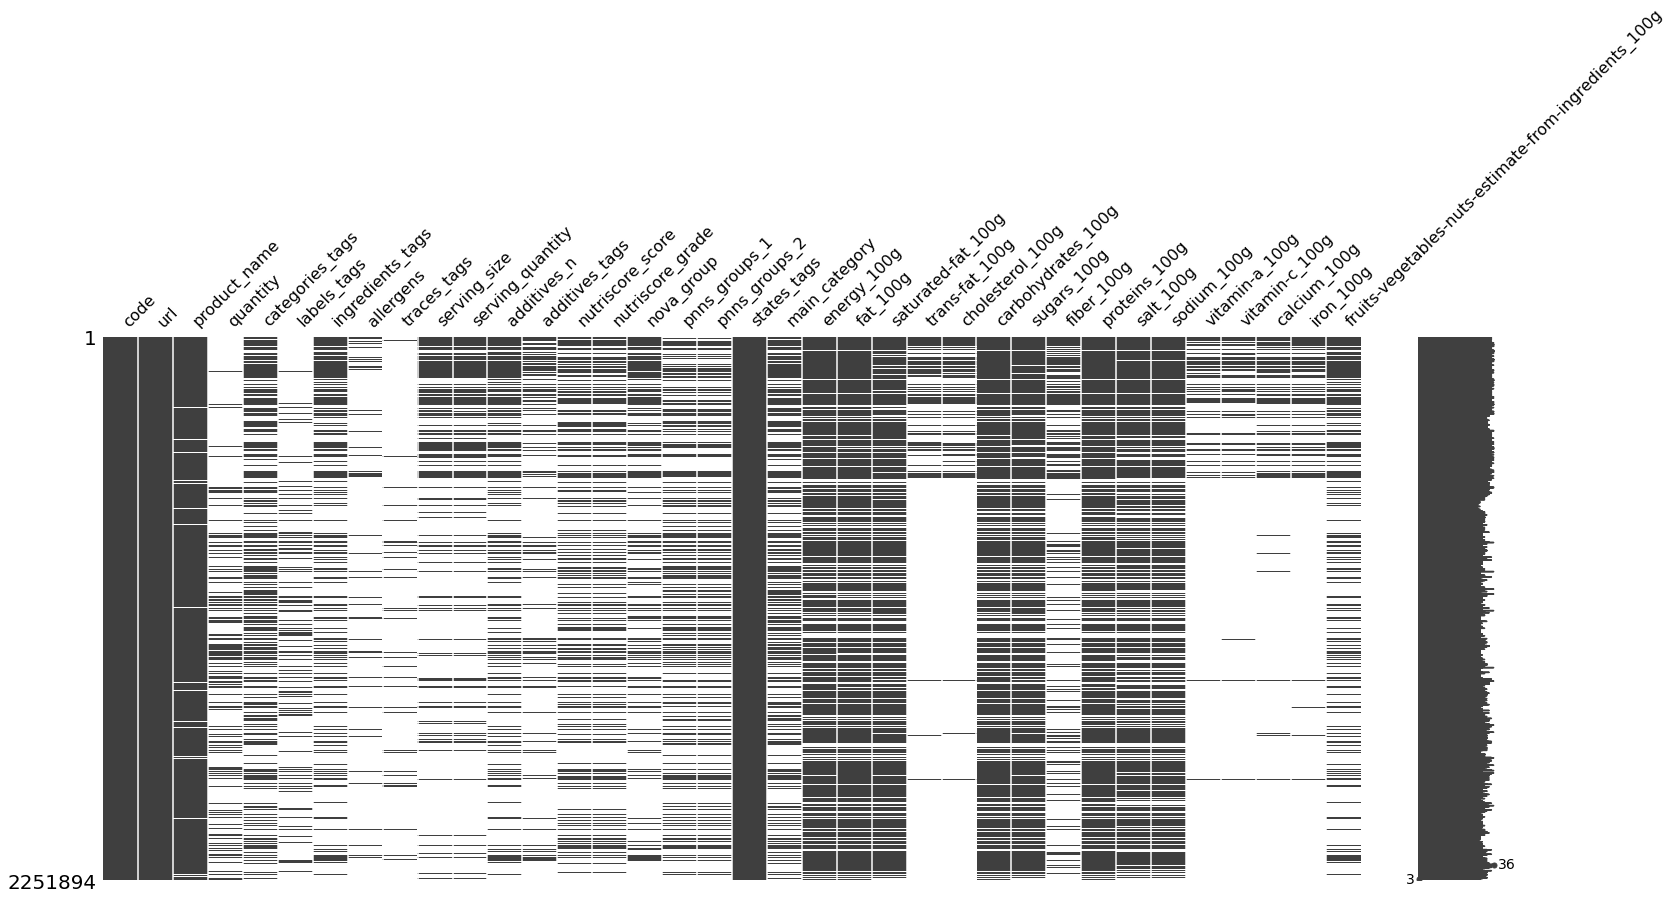

In [21]:
import missingno as msno
msno.matrix(data)

#### Avant d'aller plus loin, renommons la colonne `fruits-vegetables-nuts-estimate-from-ingredients_100g`
pour faciliter la visualisation des tableaux & graphiques à venir

In [22]:
data.rename(columns={'fruits-vegetables-nuts-estimate-from-ingredients_100g':'FVN_estimate_100g'}, inplace=True)

# 3. Préselection des colonnes utiles <a class="anchor" id="P03"></a>

Malgré une première sélection, il reste encore beaucoup de colonnes dans ce jeu de données. Nous allons donc nous appuyer sur les les indications de la documentation du Nutri-grade pour essayer de trouver les colonnes les plus utiles ([Voir les infos dans l'objectif du projet](#P01))

Pour rappel, voici les éléments utilisés dans le calcule du Nutri-score et donc du Nutri-grade.

#### Éléments défavorables au score

- Apport calorique pour cent grammes.
- Teneur en sucre.
- Teneur en graisses saturées.
- Teneur en sel.

#### Éléments favorables au score

- Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive.
- Teneur en fibres.
- Teneur en protéines.

In [23]:
data.columns

Index(['code', 'url', 'product_name', 'quantity', 'categories_tags',
       'labels_tags', 'ingredients_tags', 'allergens', 'traces_tags',
       'serving_size', 'serving_quantity', 'additives_n', 'additives_tags',
       'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1',
       'pnns_groups_2', 'states_tags', 'main_category', 'energy_100g',
       'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g', 'FVN_estimate_100g'],
      dtype='object')

### `Informations nutritionelles`
> Prenons déjà tous les indicateurs nutritionnels `*_100g`

In [24]:
var_selected = {x for x in data.columns if x.endswith('_100g')}

### `Informations de catégorisation du produit`

> Afin de pouvoir explorer la relation entre le type de produit et les variables que nous avons gardé précédemment, nous allons garder une colonne de catégorisation.

> Il y a trois variables qui pourraient servir à catégoriser les produits; `main_category`, `pnns_groups_1` et `pnns_groups_2`.

#### Regardons les trois colonnes candidates plus en détails

In [25]:
from itertools import zip_longest

In [26]:
def eval_groups(maxiter=20):
    x = data.main_category.value_counts(dropna=False)
    y = data.pnns_groups_1.value_counts(dropna=False)
    z = data.pnns_groups_2.value_counts(dropna=False)

    size=25
    print(f"{'main_category'.upper().rjust(size+9)}\t{'pnns_groups_1'.upper().rjust(size+9)}\t{'pnns_groups_2'.upper().rjust(size+9)}\n{'-'*115}")
    for i,(ai,a, bi,b, ci,c) in enumerate(zip_longest(x.index,x, y.index, y,z.index, z)):
        a = 0 if a == None else a
        b = 0 if b == None else b
        c = 0 if c == None else c
        print(f"{str(ai)[:size].rjust(size)} :{a:7}\t{str(bi)[:size].rjust(size)} :{b:7}\t{str(ci)[:size].rjust(size)} :{c:7}")
        if i > maxiter:
            break
            
eval_groups(15)

                     MAIN_CATEGORY	                     PNNS_GROUPS_1	                     PNNS_GROUPS_2
-------------------------------------------------------------------------------------------------------------------
                     None :1240806	                     None :1435564	                     None :1435562
                en:snacks :  34348	            Sugary snacks : 169128	                   Sweets :  76620
                en:sauces :  17325	           Fish Meat Eggs : 115304	       Biscuits and cakes :  68817
              en:biscuits :  16543	  Milk and dairy products : 102191	     Dressings and sauces :  54952
       en:confectioneries :  16450	     Cereals and potatoes :  95113	                   Cheese :  50954
               en:cheeses :  16364	           Fat and sauces :  78861	           One-dish meals :  46234
             en:beverages :  12693	                Beverages :  74848	                  Cereals :  45444
                en:breads :  10484	    Fruit

#### Regardons le nombre de catégories dans chaque colonne

In [27]:
data[['main_category', 'pnns_groups_1', 'pnns_groups_2']].nunique()

main_category    35204
pnns_groups_1       11
pnns_groups_2       41
dtype: int64

#### Affichons leurs taux de remplissage

In [28]:
data[['main_category', 'pnns_groups_1', 'pnns_groups_2']].notnull().mean(0)

main_category   0.449
pnns_groups_1   0.363
pnns_groups_2   0.363
dtype: float64

> Bien que `main_category` soit légèrement plus remplie que les deux autres (après le nettoyage des NaN fait plus haut...), le découpage qui apparait dans `pnns_groups_2` semble être le plus intéressant car moins granulaire; on va donc prendre cette colonne.

In [29]:
var_selected.add('pnns_groups_2')

### `Informations d'identification du produit`

> Pour aider à trouver les doublons, on va ajouter les variables `code` et `product_name`.

In [30]:
var_selected.add('code')
var_selected.add('product_name')

### `Scores de référence`
> Comme le propos est de travailler sur le nutri-grade, il convient d'ajouter les colonnes concernées... mais c'est aussi l'occasion d'étudier le comportement du nova_group, donc on l'ajoute aussi.

In [31]:
var_selected.add('nutriscore_score')
var_selected.add('nutriscore_grade')
var_selected.add('nova_group') # Pour comparaison

### Colonnes séléctionnées pour une application de prédiction du Nutri-grade

In [32]:
var_selected

{'FVN_estimate_100g',
 'calcium_100g',
 'carbohydrates_100g',
 'cholesterol_100g',
 'code',
 'energy_100g',
 'fat_100g',
 'fiber_100g',
 'iron_100g',
 'nova_group',
 'nutriscore_grade',
 'nutriscore_score',
 'pnns_groups_2',
 'product_name',
 'proteins_100g',
 'salt_100g',
 'saturated-fat_100g',
 'sodium_100g',
 'sugars_100g',
 'trans-fat_100g',
 'vitamin-a_100g',
 'vitamin-c_100g'}

In [33]:
data_nutri = data[[*var_selected]]

### Explorons à nouveau ce jeu de données réduits pour les besoins de l'application

In [34]:
data_nutri.shape

(2251894, 22)

In [35]:
data_nutri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2251894 entries, 0 to 2251893
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   nutriscore_score    float64
 1   carbohydrates_100g  float64
 2   vitamin-c_100g      float64
 3   pnns_groups_2       object 
 4   sugars_100g         float64
 5   nova_group          object 
 6   fat_100g            float64
 7   sodium_100g         float64
 8   energy_100g         float64
 9   product_name        object 
 10  saturated-fat_100g  float64
 11  proteins_100g       float64
 12  salt_100g           float64
 13  FVN_estimate_100g   float64
 14  nutriscore_grade    object 
 15  trans-fat_100g      float64
 16  fiber_100g          float64
 17  iron_100g           float64
 18  calcium_100g        float64
 19  code                object 
 20  vitamin-a_100g      float64
 21  cholesterol_100g    float64
dtypes: float64(17), object(5)
memory usage: 378.0+ MB


In [36]:
data_nutri.describe().T

count                                           mean  \
nutriscore_score    776383.000                                          9.091   
carbohydrates_100g 1776746.000                                      56274.039   
vitamin-c_100g      220782.000                                          0.114   
sugars_100g        1758313.000                                   56929545.382   
fat_100g           1777186.000                               562754208033.989   
sodium_100g        1640251.000                                      24371.247   
energy_100g        1786722.000      3730607721228534090965745911682039808.000   
saturated-fat_100g 1731439.000                                      57722.281   
proteins_100g      1778610.000                                      56198.842   
salt_100g          1640254.000                                      60928.005   
FVN_estimate_100g   753817.000                                          8.602   
trans-fat_100g      265364.000                                          0.162   
fiber_100g          639994.000 153333860029341582185095018443795150667776.000   
iron_100g           265735.000                                          0.038   
calcium_100g        271880.000                                        736.131   
vitamin-a_100g      212955.000                                          1.671   
cholesterol_100g    269384.000                                          0.060   

                                                                 std      min  \
nutriscore_score                                               8.849  -15.000   
carbohydrates_100g                                      74971304.959   -1.000   
vitamin-c_100g                                                21.591    0.000   
sugars_100g                                          75414025717.789   -1.000   
fat_100g                                         750124863814886.500    0.000   
sodium_100g                                             31211351.831    0.000   
energy_100g             4986640698625920150338062244302641168384.000    0.000   
saturated-fat_100g                                      75945867.241    0.000   
proteins_100g                                           74932009.551 -500.000   
salt_100g                                               78028308.222    0.000   
FVN_estimate_100g                                             36.118    0.000   
trans-fat_100g                                                29.665    0.000   
fiber_100g         122666513020150478865288974968710559086673920.000   -6.700   
iron_100g                                                      6.442   -0.000   
calcium_100g                                              383567.119    0.000   
vitamin-a_100g                                               371.121   -0.000   
cholesterol_100g                                               1.951    0.000   

                       25%      50%      75%  \
nutriscore_score     1.000   10.000   16.000   
carbohydrates_100g   3.529   15.380   53.000   
vitamin-c_100g       0.000    0.000    0.004   
sugars_100g          0.600    3.570   17.100   
fat_100g             0.800    7.000   21.200   
sodium_100g          0.033    0.236    0.560   
energy_100g        418.000 1079.000 1674.000   
saturated-fat_100g   0.100    1.800    7.000   
proteins_100g        1.300    6.000   12.500   
salt_100g            0.083    0.590    1.400   
FVN_estimate_100g    0.000    0.000    0.500   
trans-fat_100g       0.000    0.000    0.000   
fiber_100g           0.000    1.600    3.700   
iron_100g            0.000    0.001    0.002   
calcium_100g         0.000    0.036    0.111   
vitamin-a_100g       0.000    0.000    0.000   
cholesterol_100g     0.000    0.000    0.022   

                                                                  max  
nutriscore_score                                               40.000  
carbohydrates_100g                                    99932728111.000  
vitamin-c_100g            

> On remarque que beaucoup de colonnes numériques ont des valeurs `min`, `max` *(et donc `mean` et `std`)* clairement hors normes.
>
> Il va falloir s'occuper de toutes ces valeurs aberrantes.
---

In [37]:
data_nutri.describe(exclude="number").T

count   unique            top    freq
pnns_groups_2      816332       41         Sweets   76620
nova_group         679561        4              4  440248
product_name      2166178  1387468           Miel    1449
nutriscore_grade   776383        5              d  240061
code              2251894  2251873  3477610001135       2

> Sur la base des colonnes `code` *(sensées être uniques)*, on remarque qu'il y a au moins un doublon. Il faudra donc le(s) supprimer ([voir ici](#clean_duplicates)).
---

#### Affichons les taux de valeurs manquantes pour chaque colonne.

In [38]:
fill_ratio = print_fill_rate(data_nutri, data_nutri.columns)

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
  nutriscore_score |         1475511 |           34.48%
carbohydrates_100g |          475148 |           78.90%
    vitamin-c_100g |         2031112 |            9.80%
     pnns_groups_2 |         1435562 |           36.25%
       sugars_100g |          493581 |           78.08%
        nova_group |         1572333 |           30.18%
          fat_100g |          474708 |           78.92%
       sodium_100g |          611643 |           72.84%
       energy_100g |          465172 |           79.34%
      product_name |           85716 |           96.19%
saturated-fat_100g |          520455 |           76.89%
     proteins_100g |          473284 |           78.98%
         salt_100g |          611640 |           72.84%
 FVN_estimate_100g |         1498077 |           33.47%
  nutriscore_grade |         1475511 |          

<AxesSubplot:>

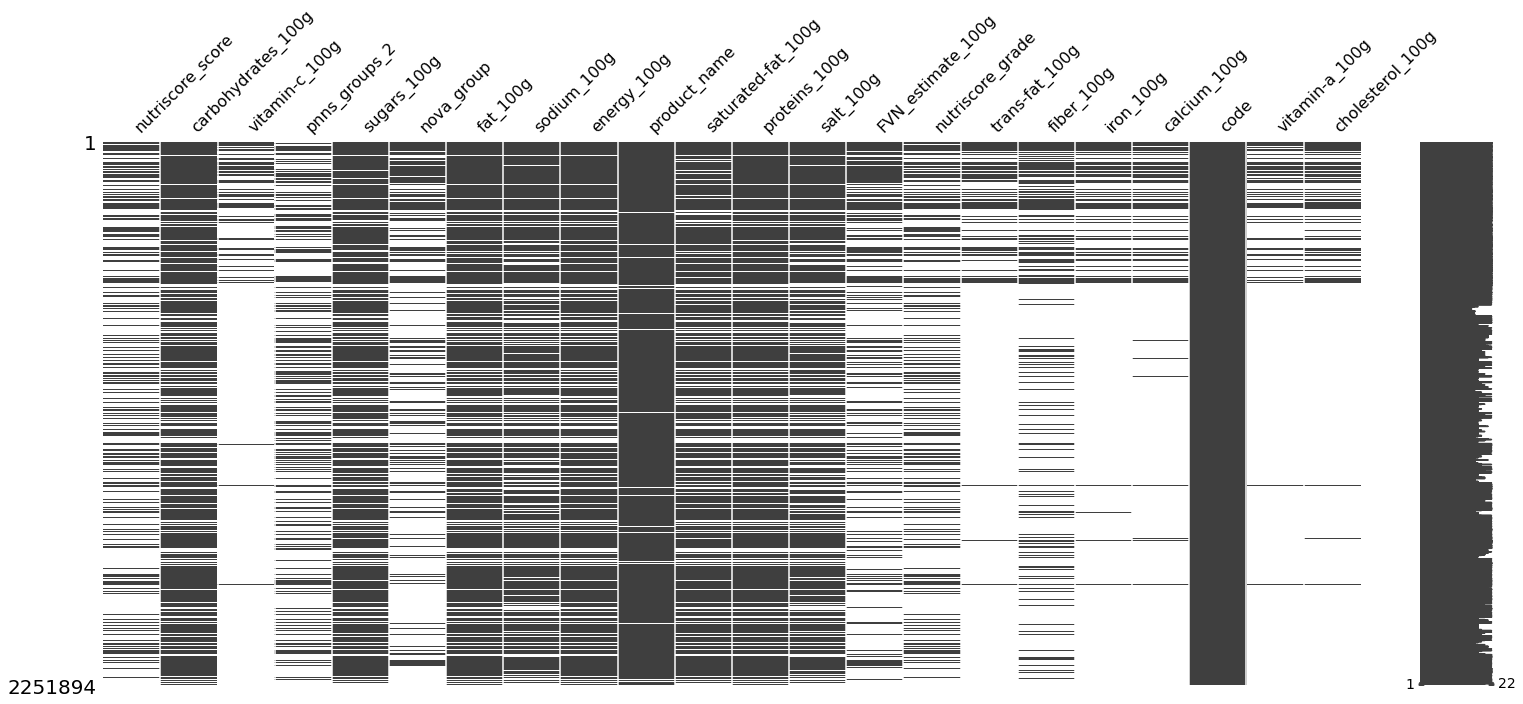

In [39]:
msno.matrix(data_nutri)

# 4. Nettoyage du jeu de données <a class="anchor" id="P04"></a>

In [40]:
data_clean = data_nutri.copy()

## 4.1 Suppression des doublons <a class="anchor" id="clean_duplicates"></a>
Pour ce faire, nous allons nous appuyer sur la colonne `code` dans un premier temps, et sur le reste des colonnes dans un second temps.

In [41]:
data_clean['code'].describe()

count           2251894
unique          2251873
top       3477610001135
freq                  2
Name: code, dtype: object

In [42]:
data_clean['code'].isnull().sum()

0

In [43]:
data_clean.shape[0] - len(data_clean['code'].unique())

21

> Toutes les lignes du jeu de donnée ont un code, et 21 d'entre elles sont des doublons.

#### Supprimons les doublons sur `code`

In [44]:
data_tmp = data_clean.copy()

In [45]:
duplicated = data_tmp.code.duplicated(keep='first')
duplicated.sum()

21

In [46]:
data_tmp.drop_duplicates(subset=['code'], keep='first', inplace=True) 

> Nous avons donc supprimé 21 produits en double.

#### Ensuite vérifions si il y a des lignes similaires en excluant le code-barre

In [47]:
cols_without_code = list(data_tmp.columns)
cols_without_code.remove("code")

In [48]:
duplicated = data_tmp[cols_without_code].duplicated(keep='first')
duplicated.sum()

231726

> Il y a 231 726 produits qui en dehors du code-barre sont totalement identiques à un autre.
>
> Dans la mesure où ouvrir plusieurs fois le même produit avec exactement les même valeurs ne semble pas utile, supprimons les.

In [49]:
data_tmp.shape

(2251873, 22)

In [50]:
data_tmp.drop_duplicates(subset=cols_without_code, keep='first', inplace=True)

In [51]:
data_tmp.shape

(2020147, 22)

In [52]:
duplicated = data_tmp[cols_without_code].duplicated(keep='first')
duplicated.sum()

0

> Il n'y a visiblement pas d'autres doublons.

#### Reportons les modifications sur le data_clean

In [53]:
data_clean.shape

(2251894, 22)

In [54]:
data_clean = data_tmp.copy()
data_clean.shape

(2020147, 22)

## 4.2 Suppressions des valeurs aberrantes <a class="anchor" id="clean_outliers"></a>

In [55]:
data_tmp = data_clean.copy()

Les valeurs nutritionnelles `*_100g` ne peuvent logiquement pas dépasser les 100g, ni avoir moins de 0g.

Deux options se présentent à nous:
1. Remplacer les valeurs aberrantes par des None et les imputer ensuite.
2. Supprimer les lignes qui présentent des valeurs aberrantes en partant du principe que si une donnée de la ligne est fausse, les autres sont incertaines.

> Nous allons donc procèder en deux temps... d'abord supprimer les lignes qui sont en dehors de l'intervalle logique [0,100], puis ensuite remplacer les valeurs aberrantes en regard des valeurs maximum connues pour un nutriment donnée.

#### Supprimons les lignes dont les valeurs nutritionnelles sont hors intervalle [0,100] 
Sauf `energy_100g` qui est en kj.

In [56]:
var_nutri = [x for x in data_tmp.columns if x.endswith('_100g') and x != 'energy_100g']

In [57]:
data_tmp[var_nutri].describe().T

count                                           mean  \
carbohydrates_100g 1701875.000                                      58748.931   
vitamin-c_100g      210426.000                                          0.119   
sugars_100g        1682172.000                                   59506375.708   
fat_100g           1702146.000                               587563522728.239   
sodium_100g        1565679.000                                      25532.003   
saturated-fat_100g 1657146.000                                      60309.794   
proteins_100g      1703622.000                                      58672.006   
salt_100g          1565682.000                                      63829.885   
FVN_estimate_100g   721954.000                                          8.599   
trans-fat_100g      251136.000                                          0.170   
fiber_100g          622228.000 157711884414745778957552239679481223053312.000   
iron_100g           252498.000                                          0.040   
calcium_100g        258531.000                                        774.135   
vitamin-a_100g      202767.000                                          1.754   
cholesterol_100g    255239.000                                          0.062   

                                                                 std      min  \
carbohydrates_100g                                      76602671.205   -1.000   
vitamin-c_100g                                                22.116    0.000   
sugars_100g                                          77101888984.800   -1.000   
fat_100g                                         766481361043963.250    0.000   
sodium_100g                                             31945991.490    0.000   
saturated-fat_100g                                      77629601.563    0.000   
proteins_100g                                           76563384.769 -500.000   
salt_100g                                               79864902.211    0.000   
FVN_estimate_100g                                             36.536    0.000   
trans-fat_100g                                                30.494    0.000   
fiber_100g         124405389717845841549860044370365748768407552.000   -6.700   
iron_100g                                                      6.609   -0.000   
calcium_100g                                              393345.049    0.000   
vitamin-a_100g                                               380.330   -0.000   
cholesterol_100g                                               2.004    0.000   

                     25%    50%    75%  \
carbohydrates_100g 3.800 16.129 53.300   
vitamin-c_100g     0.000  0.000  0.004   
sugars_100g        0.680  3.600 18.000   
fat_100g           0.800  7.000 21.000   
sodium_100g        0.034  0.232  0.560   
saturated-fat_100g 0.100  1.790  7.000   
proteins_100g      1.300  6.000 12.000   
salt_100g          0.085  0.580  1.400   
FVN_estimate_100g  0.000  0.000  0.860   
trans-fat_100g     0.000  0.000  0.000   
fiber_100g         0.000  1.600  3.700   
iron_100g          0.000  0.001  0.002   
calcium_100g       0.000  0.038  0.111   
vitamin-a_100g     0.000  0.000  0.000   
cholesterol_100g   0.000  0.000  0.022   

                                                                  max  
carbohydrates_100g                                    99932728111.000  
vitamin-c_100g                                               8000.000  
sugars_100g                                       100000000376832.000  
fat_100g                                      1000000000000000000.000  
sodium_100g                                           39973091244.400  
saturated-fat_100g                                    99932728111.000  
proteins_100g                                         99932728111.000  
salt_100g                                             99932728111.000  
FVN_estimate_100g                                           13461.000  
trans-fat_100g                        

In [58]:
# Définissons une fonction permettant de supprimer les lignes qui présentent des valeurs hors intervalle

def drop_row_values(dt, col_name, min_v=None, max_v=None):
    count_start = dt.shape[0]
    
    dt = dt[((dt[col_name].notnull()) & (dt[col_name] >= min_v) & (dt[col_name] <= max_v)) | (dt[col_name].isnull())]
        
    count_end = dt[col_name].shape[0]
    print(f"On a supprimé {count_start-count_end:6} lignes sur {col_name}")
        
    return dt

In [59]:
for col in var_nutri:
    data_tmp = drop_row_values(data_tmp, col, min_v=0, max_v=100)

On a supprimé    424 lignes sur carbohydrates_100g
On a supprimé      9 lignes sur vitamin-c_100g
On a supprimé     39 lignes sur sugars_100g
On a supprimé    167 lignes sur fat_100g
On a supprimé    861 lignes sur sodium_100g
On a supprimé     29 lignes sur saturated-fat_100g
On a supprimé     69 lignes sur proteins_100g
On a supprimé    384 lignes sur salt_100g
On a supprimé   1078 lignes sur FVN_estimate_100g
On a supprimé     27 lignes sur trans-fat_100g
On a supprimé     58 lignes sur fiber_100g
On a supprimé      7 lignes sur iron_100g
On a supprimé    126 lignes sur calcium_100g
On a supprimé    150 lignes sur vitamin-a_100g
On a supprimé      6 lignes sur cholesterol_100g


In [60]:
data_tmp.shape

(2016713, 22)

In [61]:
data_tmp[var_nutri].describe().T

count   mean    std   min   25%    50%    75%     max
carbohydrates_100g 1698675.000 28.531 27.864 0.000 3.800 16.100 53.300 100.000
vitamin-c_100g      210209.000  0.032  0.906 0.000 0.000  0.000  0.004 100.000
sugars_100g        1679284.000 13.141 19.325 0.000 0.680  3.600 18.000 100.000
fat_100g           1698931.000 13.510 17.362 0.000 0.800  7.000 21.000 100.000
sodium_100g        1562895.000  0.548  1.869 0.000 0.034  0.232  0.560  49.987
saturated-fat_100g 1654289.000  4.989  7.746 0.000 0.100  1.790  7.000 100.000
proteins_100g      1700419.000  8.590 10.021 0.000 1.300  6.000 12.000 100.000
salt_100g          1562898.000  1.370  4.672 0.000 0.084  0.580  1.400 100.000
FVN_estimate_100g   720032.000  8.232 21.543 0.000 0.000  0.000  0.700 100.000
trans-fat_100g      250886.000  0.047  0.747 0.000 0.000  0.000  0.000  90.000
fiber_100g          620084.000  3.208  5.627 0.000 0.000  1.600  3.700 100.000
iron_100g           252225.000  0.009  0.371 0.000 0.000  0.001  0.002 100.000
calcium_100g        258153.000  0.137  1.528 0.000 0.000  0.038  0.111 100.000
vitamin-a_100g      202501.000  0.028  1.283 0.000 0.000  0.000  0.000 100.000
cholesterol_100g    254982.000  0.048  1.308 0.000 0.000  0.000  0.022 100.000

Par ailleurs, en cherchant sur Internet on peut trouver les valeurs réelles maximales constatées pour plusieurs de ces colonnes.

> Pour `cholesterol_100g` le maximum semble être à **3.1g** (3100mg) pour 100g /// **Cervelle de veau cuite**

> Pour `fat_100g` le maximum semble être à **100g** pour 100g /// **Huile d'avocat**

> Pour `saturated-fat_100g` le maximum semble être à **92.6** pour 100g /// **Pain de friture**

> Pour `proteins_100g` le maximum semble être à **87.6g** pour 100g /// **Gélatine alimentaire**

> Pour `sugars_100g` le maximum semble être à **99.8g** pour 100g /// **Fructose**

> Pour `carbohydrates_100g` le maximum semble être à **99.8g** pour 100g /// **Fructose**

> Pour `sodium_100g` le maximum semble être à **39.1g** (39100 mg)pour 100g /// **Sel blanc non iodé non fluoré**

> Pour `salt_100g` le maximum semble être à **100g** pour 100g /// **Sel blanc non iodé non fluoré**

> Pour `iron_100g` le maximum semble être à **0,0064g** (6.4 mg) pour 100g /// **Boudin noir**

> Pour `calcium_100g` le maximum semble être à **2g** (2000 mg) pour 100g /// **Meloukhia en poudre**

> Pour `fiber_100g` le maximum semble être à **43.5g** pour 100g /// **Cannelle**

> Pour `energy-kcal_100g` le maximum semble être à **900 kcal** pour 100g /// **Huile d'avocat**

> Pour `energy-kj_100g` le maximum semble être à **3765.6 kcal** pour 100g /// **Huile d'avocat**

> Pour `vitamin-a_100g` le maximum semble être à **0.03g** (30 000 μg) pour 100g /// **Huile de de foie de morrue**

> Pour `vitamin-c_100g` le maximum semble être à **0.2g** (200 mg) pour 100g /// **Cassis**

#### Remplaçons les valeurs nutritionnelles hors intervalle connu par des None pour pouvoir ensuite les imputer

In [62]:
max_values = {
    'cholesterol_100g':3.1,
    'fat_100g':100,
    'saturated-fat_100g':92.6,
    'proteins_100g':87.6,
    'sugars_100g':99.8,
    'carbohydrates_100g':99.8,
    'sodium_100g':39.1,
    'salt_100g':100,
    'iron_100g':0.0064,
    'calcium_100g':2,
    'fiber_100g':43.5,
    'energy_100g':3756.6,
    'vitamin-a_100g':0.03,
    'vitamin-c_100g':0.2,
}

In [63]:
# Définissons une fonction permettant d'appliquer un filtre sur les valeurs hors bornes

def clip_column_values(dt, col_name, min_v=None, max_v=None, min_new=None, max_new=None):
    count_start = dt[col_name].isin([max_new,min_new]).sum()
    
    if(min_v != None):
        dt[col_name].mask(dt[col_name] < min_v, min_new, inplace=True)
    if(max_v != None):
        dt[col_name].mask(dt[col_name] > max_v, max_new, inplace=True)
        
    count_end = dt[col_name].isin([max_new,min_new]).sum()
    
    print(f"On a modifié {count_end-count_start:6} lignes sur {col_name}")
        
    return dt

In [64]:
for col in max_values:
    data_tmp = clip_column_values(data_tmp, col, max_v=max_values[col], max_new=None)

On a modifié    196 lignes sur cholesterol_100g
On a modifié      0 lignes sur fat_100g
On a modifié    660 lignes sur saturated-fat_100g
On a modifié   1140 lignes sur proteins_100g
On a modifié   2965 lignes sur sugars_100g
On a modifié   6946 lignes sur carbohydrates_100g
On a modifié    828 lignes sur sodium_100g
On a modifié      0 lignes sur salt_100g
On a modifié  12294 lignes sur iron_100g
On a modifié    448 lignes sur calcium_100g
On a modifié   1880 lignes sur fiber_100g
On a modifié  12540 lignes sur energy_100g
On a modifié    247 lignes sur vitamin-a_100g
On a modifié   1819 lignes sur vitamin-c_100g


In [65]:
data_tmp[[*var_nutri, 'energy_100g']].describe().T

count     mean     std   min     25%      50%  \
carbohydrates_100g 1691729.000   28.238  27.541 0.000   3.800   16.000   
vitamin-c_100g      208390.000    0.006   0.017 0.000   0.000    0.000   
sugars_100g        1676319.000   12.988  18.993 0.000   0.650    3.600   
fat_100g           1698931.000   13.510  17.362 0.000   0.800    7.000   
sodium_100g        1562067.000    0.527   1.638 0.000   0.033    0.232   
saturated-fat_100g 1653629.000    4.953   7.535 0.000   0.100    1.790   
proteins_100g      1699279.000    8.534   9.785 0.000   1.300    6.000   
salt_100g          1562898.000    1.370   4.672 0.000   0.084    0.580   
FVN_estimate_100g   720032.000    8.232  21.543 0.000   0.000    0.000   
trans-fat_100g      250886.000    0.047   0.747 0.000   0.000    0.000   
fiber_100g          618204.000    3.029   4.516 0.000   0.000    1.600   
iron_100g           239931.000    0.001   0.001 0.000   0.000    0.001   
calcium_100g        257705.000    0.096   0.176 0.000   0.000    0.037   
vitamin-a_100g      202254.000    0.000   0.001 0.000   0.000    0.000   
cholesterol_100g    254786.000    0.019   0.043 0.000   0.000    0.000   
energy_100g        1695710.000 1115.610 779.528 0.000 418.000 1071.000   

                        75%      max  
carbohydrates_100g   53.000   99.800  
vitamin-c_100g        0.004    0.200  
sugars_100g          17.860   99.800  
fat_100g             21.000  100.000  
sodium_100g           0.560   39.091  
saturated-fat_100g    7.000   92.600  
proteins_100g        12.000   87.600  
salt_100g             1.400  100.000  
FVN_estimate_100g     0.700  100.000  
trans-fat_100g        0.000   90.000  
fiber_100g            3.700   43.500  
iron_100g             0.002    0.006  
calcium_100g          0.110    2.000  
vitamin-a_100g        0.000    0.030  
cholesterol_100g      0.022    3.000  
energy_100g        1665.000 3756.000

#### Reportons les modifications sur le data_clean

In [66]:
data_clean.shape

(2020147, 22)

In [67]:
data_clean = data_tmp.copy()
data_clean.shape

(2016713, 22)

## 4.3 Corrélations linéaires <a class="anchor" id="clean_correlations"></a>
On va étudier les corrélations linéaires des variables quantitatives pour voir ce qui peut être fait au niveau des imputations.

Il existe plusieurs types de relations entre des variables numériques. Par exemple les rélations linéaires ou encore les relations monotones.
- Dans une relation linéaire, les variables se déplacent dans la même direction à un rythme constant.
- Dans une relation monotone, les variables ont tendance à se déplacer dans la même direction relative, mais pas nécessairement à un rythme constant.

Pour ces deux mesures les valeurs peuvent aller de -1 à 1 (inclus):
- -1 indique une relation forte dans le sens inverse (corrélation négative)
- +1 indique une relation forte dans le même sens (corrélation positive)
- 0  indique qu'il n'y a pas de relation.

Calculons donc les deux pour voir si quelque chose s'en dégage.

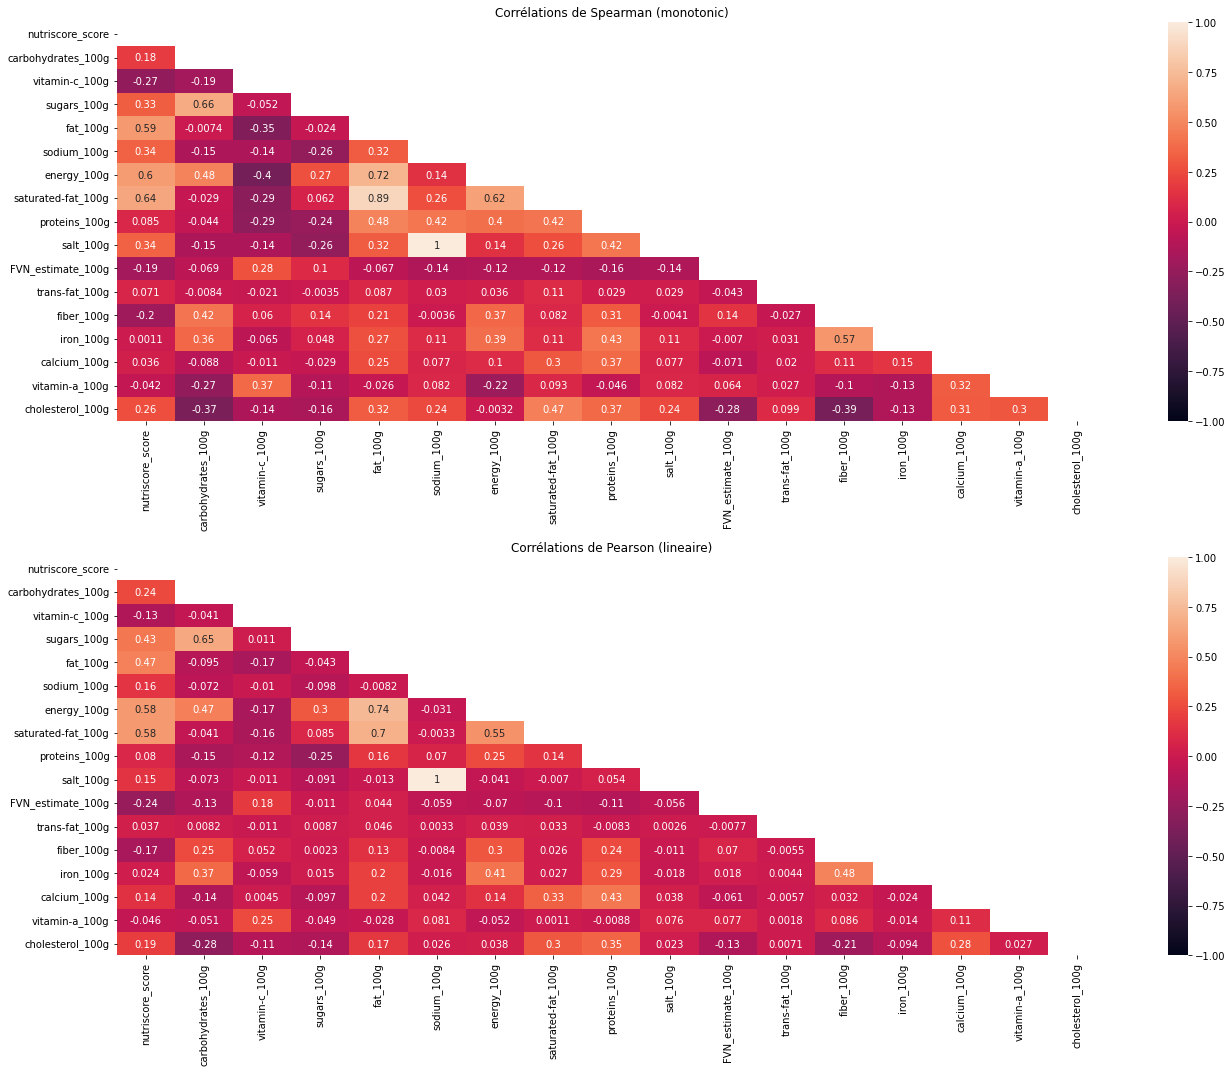

In [68]:
fig = plt.figure(figsize=(19,15))

plt.subplot(2,1,1)
corr= data_clean.corr(method="spearman")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Spearman (monotonic)')
#ax.legend()

plt.subplot(2,1,2)
corr= data_clean.corr(method="pearson")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Pearson (lineaire)')
#ax.legend()

fig.tight_layout()
plt.show()

> Si on s'intéresse à la colonne **`nutriscore_score`**, on remarque qu'elle est **corrélée à divers degrès avec la plupart des colonnes** considerées comme favorables ou défavorables dans la documentation:
> 
> #### Éléments défavorables au score:
> 
> - `energy_100g` = 0.58 / 0.60 << **Apport calorique pour cent grammes**.
> - `sugars_100g` = 0.43 / 0.33 << **Teneur en sucre**.
> - `saturated-fat_100g` = 0.58 / 0.64 << **Teneur en graisses saturées**.
> - `salt_100g` = 0.15 / 0.34 << **Teneur en sel**.
>
> #### Éléments favorables au score:
>
> - `FVN_estimate_100g` = -0.24 / -0.19 << **Teneur en fruits, légumes, légumineuses, oléagineux, huiles de colza, de noix et d'olive**.
> - `fiber_100g` = -0.17 / -0.2 << **Teneur en fibres**.
> - `proteins_100g` = 0.08 / 0.085 << **Teneur en protéines**.
>
> Le sens des corrélations constatées est d'ailleurs raccord avec ce que l'on était en droit d'espèrer d'après la documentation du Nutriscore *(plus le `nutriscore_score` est grand moins c'est favorable et inversement plus il est bas et plus c'est favorable)*; une corrélation positive (avec un mauvais score) pour `energy_100g`, `sugars_100g`, `saturated-fat_100g`, `salt_100g` et une corrélation négative (avec un mauvais score) pour `fiber_100g`, `FNV_estimate_100g`. Seule la colonne `proteins_100g` ne semble pas répondre aux attentes, mais la laison avec le score ne semble de toutes façons pas très forte.
>
> #### Par ailleurs, on note également des corrélations moyennes avec des éléments non pris en compte par la documentation:
>
> - `fat_100g` = 0.47 / 0.59
> - `cholesterol_100g` = 0.19 / 0.26
> - `carbohydrates_100g` = 0.24 / 0.18
> - `calcium_100g` = 0.14 / 0.036
> - `sodium_100g` = 0.16 / 0.34
> - `vitamin-c_100g` = -0.13 / -0.27

> Si l'on regade les autres colonnes, on voit que certaines d'entre elles n'ont **aucune corrélation linéaire** *(Pearson)* avec les autres et très peu de corrélation monotones *(Spearman)*.
> - C'est le cas de `trans-fat_100g` qui de fait ne devrait pas être très utiles ni pour prédire le `nutriscore-score` ni pour imputer les autres colonnes.
>
> En revanche, certaines colonnes présentent des corrélations moyennes ou fortes intéressantes:
> - La corrélation est maximale entre `salt_100g` et `sodium_100g` *(ce qui n'est en soit pas étonnant car pour effectuer une conversion entre sodium et sel, il faut multiplier la quantité de sodium par 2,54)*.
> - La corrélation est haute entre `energy_100g` et `fat_100g`.
> - La corrélation est moyenne entre `energy_100g` et `carbohydrates_100g`, `proteins_100g`, `calcium_100g`, `saturated-fat_100g` ou `fiber_100g`.
> - La corrélation est moyenne ou basse entre plusieurs types de graisses `fat_100g`, `saturated-fat_100g`, `cholesterol_100g`.

---

#### Vérifions les relations entre `nutriscore_score` et les autres variables numériques
avec des `régressions linéaires` et le `coéfficient de détermination R²`

Pour le coéfficient de détermination R², les valeurs peuvent aller de 0 à 1 (inclus):
- 1 indique une relation forte.
- 0  indique qu'il n'y a pas de relation.


In [69]:
var_nutri = [x for x in data_clean.columns if x.endswith('_100g')]
data_sample = data_clean.sample(frac=0.1, random_state=0)
data_sample.dropna(inplace=True)

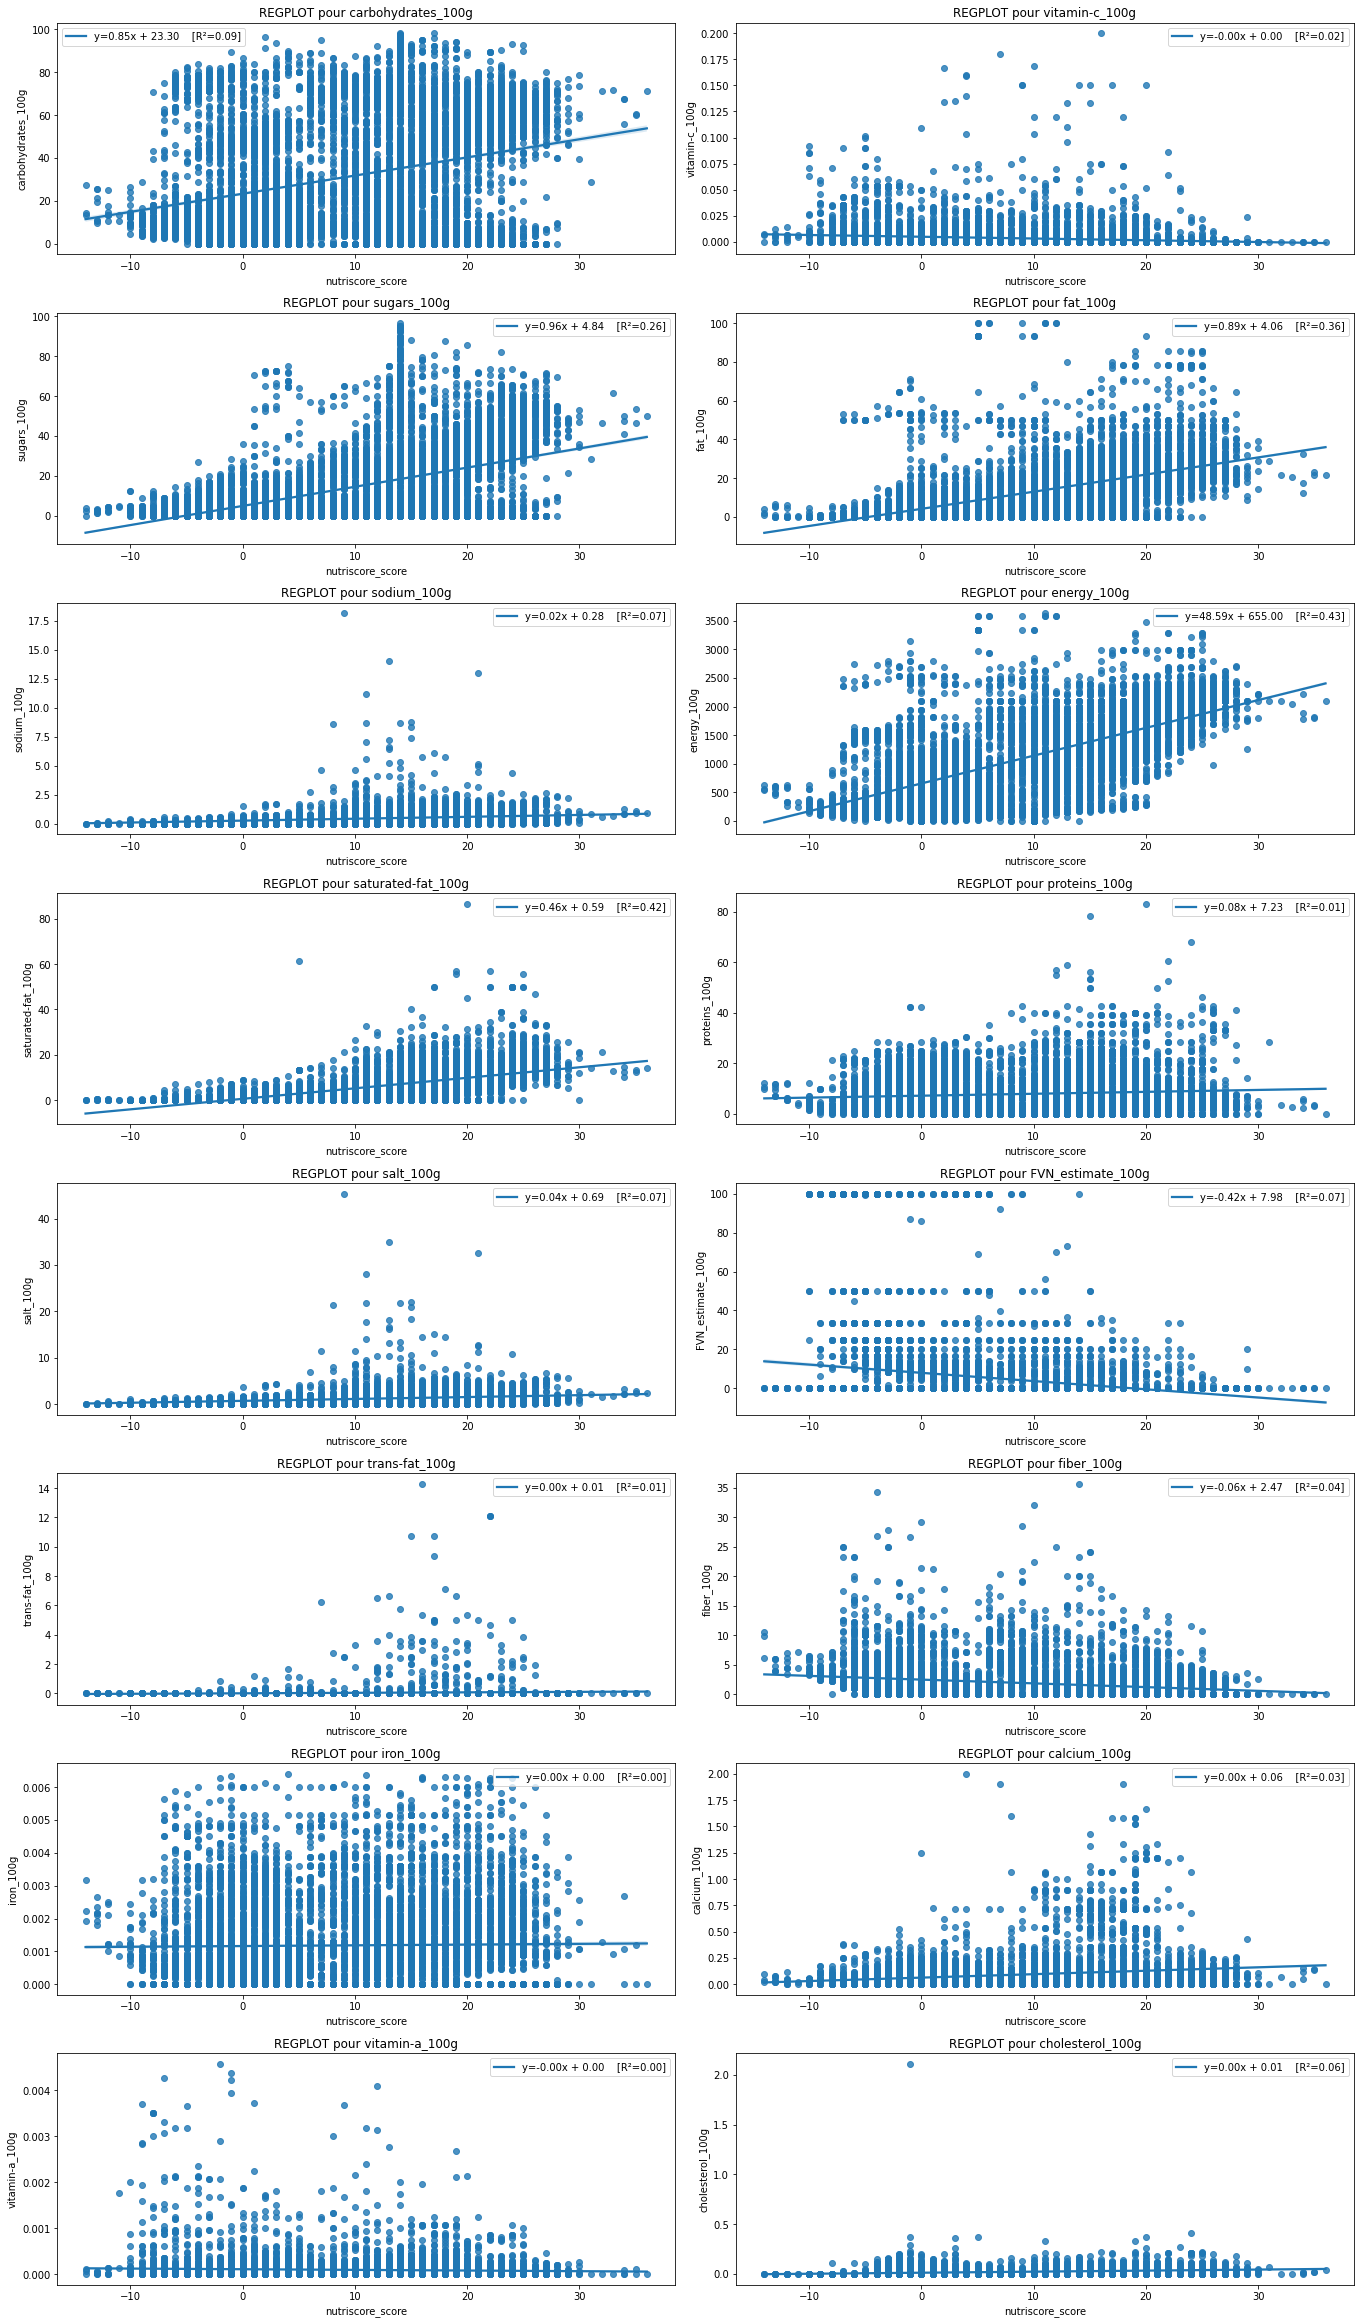

In [70]:
from scipy import stats

fig = plt.figure(figsize=(19,40))

for i, col in enumerate(var_nutri):
    plt.subplot(10,2,i+1)

    slope, intercept, r_value, pv, se = stats.linregress(data_sample['nutriscore_score'], data_sample[col])
    sns.regplot(x="nutriscore_score", y=col, data=data_sample, line_kws={'label':f"y={slope:.2f}x + {intercept:.2f}    [R²={r_value**2:.2f}]"})
    #sns.jointplot(x="nutriscore_score", y=col, data=data_clean.sample(frac=0.01), kind="reg")#, stat_func=r2)
    plt.title(f"REGPLOT pour {col}")
    plt.legend()

fig.tight_layout()
plt.show()

> En regardant les coéfficients de déterminations R², on constate exactement les même tendances qu'avec les coefficients de Pearson et Spearman. On a une corrélation moyennement forte pour `saturated-fat_100g`, `energy_100g` et `sugars_100g`, une corrélation faible pour `salt_100g`, `FVN_estimate_100g` et `fiber_100g`, aucune corrélation pour `proteins_100g`.
>
> - `energy_100g`:        **R² = 0.43** *[Pearson = 0.58 & Spearman = 0.60]*
> - `saturated-fat_100g`: **R² = 0.42** *[Pearson = 0.58 & Spearman = 0.64]*
> - `sugars_100g`:        **R² = 0.26** *[Pearson = 0.43 & Spearman = 0.33]*
> - `salt_100g`:          **R² = 0.07** *[Pearson = 0.15 & Spearman = 0.34]*
> - `FVN_estimate_100g`:  **R² = 0.07** *[Pearson = -0.24 & Spearman = -0.19]*
> - `fiber_100g`:         **R² = 0.04** *[Pearson = -0.17 & Spearman = -0.20]*
> - `proteins_100g`:      **R² = 0.01** *[Pearson = 0.08 & Spearman = 0.085]*

> Cette tendance se vérifie avec la plupart des autres colonnes que nous avions remarquées plus haut:
> - `fat_100g`:           **R² = 0.36** *[Pearson = 0.47 & Spearman = 0.59]*
> - `carbohydrates_100g`  **R² = 0.09** *[Pearson = 0.24 & Spearman = 0.18]*
> - `sodium_100g`         **R² = 0.07** *[Pearson = 0.16 & Spearman = 0.34]*
> - `cholesterol_100g`    **R² = 0.06** *[Pearson = 0.19 & Spearman = 0.26]*
> - `calcium_100g`        **R² = 0.03** *[Pearson = 0.14 & Spearman = 0.036]*
> - `vitamin-c_100g`      **R² = 0.02** *[Pearson = -0.13 & Spearman = -0.27]*

## 4.4 Imputations des valeurs manquantes <a class="anchor" id="clean_imputations"></a>

In [71]:
data_tmp = data_clean.copy()

#### Commençons par regarder quelles sont les valeurs manquantes

In [72]:
var_nutri = [x for x in data_tmp.columns if x.endswith('_100g')]

In [73]:
fill_ratio = print_fill_rate(data_tmp, var_nutri)

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
carbohydrates_100g |          324984 |           83.89%
    vitamin-c_100g |         1808323 |           10.33%
       sugars_100g |          340394 |           83.12%
          fat_100g |          317782 |           84.24%
       sodium_100g |          454646 |           77.46%
       energy_100g |          321003 |           84.08%
saturated-fat_100g |          363084 |           82.00%
     proteins_100g |          317434 |           84.26%
         salt_100g |          453815 |           77.50%
 FVN_estimate_100g |         1296681 |           35.70%
    trans-fat_100g |         1765827 |           12.44%
        fiber_100g |         1398509 |           30.65%
         iron_100g |         1776782 |           11.90%
      calcium_100g |         1759008 |           12.78%
    vitamin-a_100g |         1814459 |          

#### Regardons comment se répartissent ces valeurs manquantes

<AxesSubplot:>

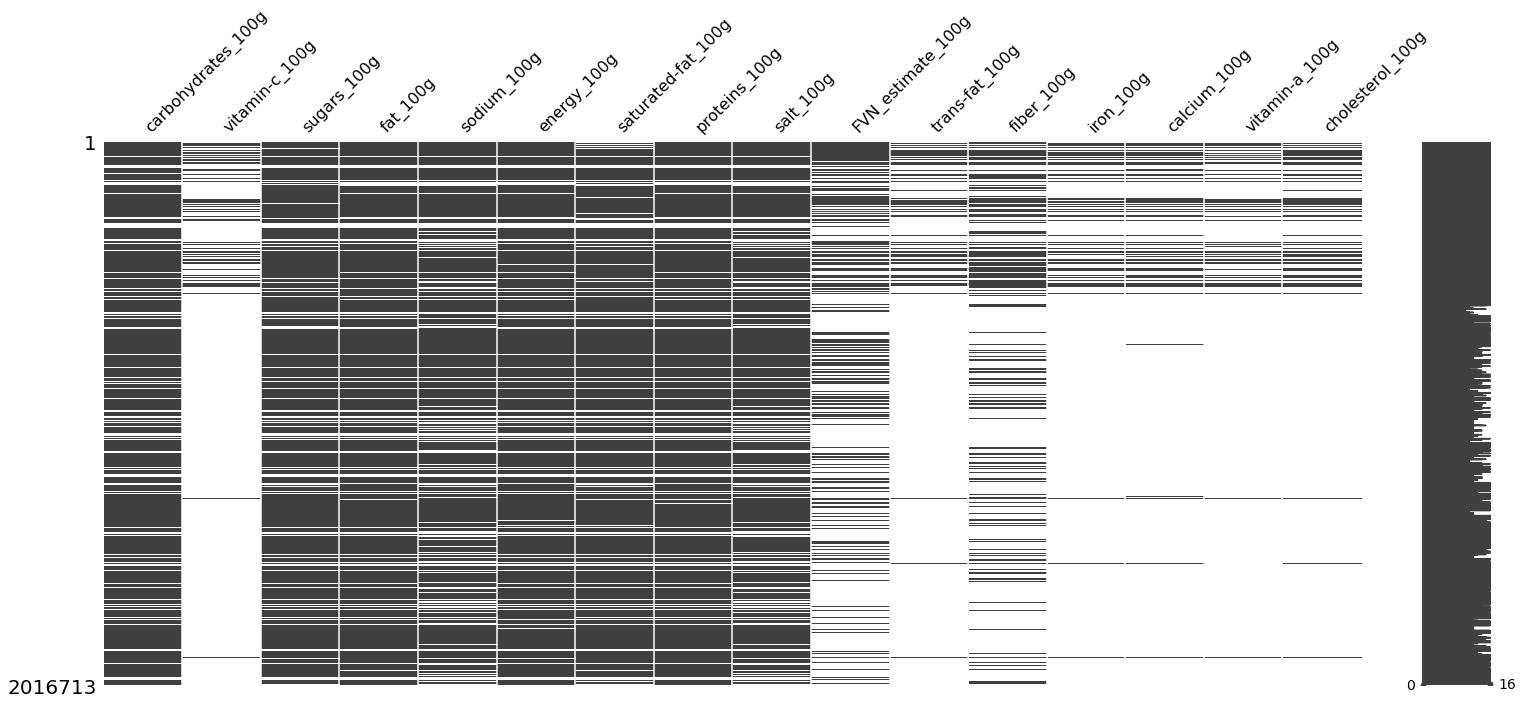

In [74]:
msno.matrix(data_tmp[var_nutri])

In [75]:
data_tmp[var_nutri].describe().T

count     mean     std   min     25%      50%  \
carbohydrates_100g 1691729.000   28.238  27.541 0.000   3.800   16.000   
vitamin-c_100g      208390.000    0.006   0.017 0.000   0.000    0.000   
sugars_100g        1676319.000   12.988  18.993 0.000   0.650    3.600   
fat_100g           1698931.000   13.510  17.362 0.000   0.800    7.000   
sodium_100g        1562067.000    0.527   1.638 0.000   0.033    0.232   
energy_100g        1695710.000 1115.610 779.528 0.000 418.000 1071.000   
saturated-fat_100g 1653629.000    4.953   7.535 0.000   0.100    1.790   
proteins_100g      1699279.000    8.534   9.785 0.000   1.300    6.000   
salt_100g          1562898.000    1.370   4.672 0.000   0.084    0.580   
FVN_estimate_100g   720032.000    8.232  21.543 0.000   0.000    0.000   
trans-fat_100g      250886.000    0.047   0.747 0.000   0.000    0.000   
fiber_100g          618204.000    3.029   4.516 0.000   0.000    1.600   
iron_100g           239931.000    0.001   0.001 0.000   0.000    0.001   
calcium_100g        257705.000    0.096   0.176 0.000   0.000    0.037   
vitamin-a_100g      202254.000    0.000   0.001 0.000   0.000    0.000   
cholesterol_100g    254786.000    0.019   0.043 0.000   0.000    0.000   

                        75%      max  
carbohydrates_100g   53.000   99.800  
vitamin-c_100g        0.004    0.200  
sugars_100g          17.860   99.800  
fat_100g             21.000  100.000  
sodium_100g           0.560   39.091  
energy_100g        1665.000 3756.000  
saturated-fat_100g    7.000   92.600  
proteins_100g        12.000   87.600  
salt_100g             1.400  100.000  
FVN_estimate_100g     0.700  100.000  
trans-fat_100g        0.000   90.000  
fiber_100g            3.700   43.500  
iron_100g             0.002    0.006  
calcium_100g          0.110    2.000  
vitamin-a_100g        0.000    0.030  
cholesterol_100g      0.022    3.000

### Etablissons une baseline pour nos imputations.
Pour ce faire, nous allons simplement imputer en utilisant les moyennes et calculer quelques scores.

In [76]:
data_imput_mean = data_tmp.copy()

#### Sélectionnons quelques lignes dont les valeurs sont connues pour servir de valeurs de référence.

In [77]:
true_values_idx = {}
for col in var_nutri:
    true_values_idx[col] = data_tmp.dropna(subset=[col]).sample(frac=0.01, random_state=0).index

#### Mettons ces lignes en None

In [78]:
for col in var_nutri:
    data_imput_mean.loc[true_values_idx[col] ,col] = None

#### Appliquons la moyenne des colonnes sur tous les None (y compris ceux que l'on vient de créer artificiellement)

In [79]:
for col in var_nutri:
    mean = data_imput_mean[col].mean()
    data_imput_mean[col].fillna(mean, inplace=True)

#### Calculons nos scores de référence (baseline with dummy model)

In [80]:
from sklearn.metrics import r2_score, mean_squared_error

In [81]:
def print_scores(dt_true, dt_pred, eval_idx):
    r2_list = []
    rmse_list = []
    for col in var_nutri:
        true_v = dt_true.loc[eval_idx[col]][col]
        pred_v = dt_pred.loc[eval_idx[col]][col]
    
        r2 = r2_score( true_v , pred_v )
        rmse = mean_squared_error( true_v, pred_v, squared=False)
        
        r2_list.append(r2)
        rmse_list.append(rmse)
        
        print(f"{col.rjust(25)}  ==>  R²:{r2:8.2f} | RMSE:{rmse:8.2f}")
    
    r2_mean = sum(r2_list)/len(r2_list)
    rmse_mean = sum(rmse_list)/len(rmse_list)
    print(f"{'-'*115}\n{'MEAN'.rjust(25)}  ==>  R²:{r2_mean:8.2f} | RMSE:{rmse_mean:8.2f}")
        
    return r2_list, rmse_list

In [82]:
_, _ = print_scores(data_tmp, data_imput_mean, true_values_idx)

       carbohydrates_100g  ==>  R²:   -0.00 | RMSE:   27.68
           vitamin-c_100g  ==>  R²:   -0.00 | RMSE:    0.02
              sugars_100g  ==>  R²:   -0.00 | RMSE:   19.19
                 fat_100g  ==>  R²:   -0.00 | RMSE:   17.19
              sodium_100g  ==>  R²:   -0.00 | RMSE:    1.56
              energy_100g  ==>  R²:   -0.00 | RMSE:  780.08
       saturated-fat_100g  ==>  R²:   -0.00 | RMSE:    7.64
            proteins_100g  ==>  R²:   -0.00 | RMSE:    9.99
                salt_100g  ==>  R²:   -0.00 | RMSE:    5.14
        FVN_estimate_100g  ==>  R²:   -0.00 | RMSE:   22.48
           trans-fat_100g  ==>  R²:   -0.00 | RMSE:    0.48
               fiber_100g  ==>  R²:   -0.00 | RMSE:    4.68
                iron_100g  ==>  R²:   -0.00 | RMSE:    0.00
             calcium_100g  ==>  R²:   -0.00 | RMSE:    0.19
           vitamin-a_100g  ==>  R²:   -0.00 | RMSE:    0.00
         cholesterol_100g  ==>  R²:   -0.00 | RMSE:    0.06
----------------------------------------

### Imputation par IterativeImputer

Dans un IterativeImputer, les colonnes sont remplies par ordre croissant; de celles qui ont le moins de valeurs manquantes à celles qui en ont le plus. Il est donc inutile d'utiliser une autre méthode au préalable pour compléter les colonnes les mieux pourvues avant d'utiliser un IterativeImputer sur le reste.

In [83]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [84]:
data_imput_iter = data_tmp.copy()

#### On met les lignes sélectionnées pour le calcul des scores en None

In [85]:
for col in var_nutri:
    data_imput_iter.loc[true_values_idx[col] ,col] = None

#### On ne garde que les colonnes qui doivent servir à prédire le `nutriscore_score`

In [86]:
X = data_imput_iter[var_nutri]
X.shape

# y = data_input_iter['nutriscore_score']

(2016713, 16)

#### On définit une liste des valeurs maximales que l'IterativeImputer peut donner à chaque colonne.

In [87]:
max_values_imput = [100.0]*len(var_nutri)
for i, col in enumerate(var_nutri):
    if(col in max_values):
        max_values_imput[i] = max_values[col]

#### On entraine l'IterativeImputer et on remplis les None

In [88]:
imputer = IterativeImputer(
    imputation_order='ascending', 
    random_state=0, 
    min_value=0, 
    max_value=max_values_imput
)
Xtrans = imputer.fit_transform(X)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P3/venvP3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



#### On replace les valeurs obtenues dans un DataFrame pandas avec les bons index et les bonnes colonnes

In [89]:
Xtrans = pd.DataFrame(Xtrans, columns=var_nutri, index=data_tmp.index)
Xtrans.shape

(2016713, 16)

#### On explore le résultat

In [90]:
fill_ratio = print_fill_rate(Xtrans, var_nutri)

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
carbohydrates_100g |               0 |          100.00%
    vitamin-c_100g |               0 |          100.00%
       sugars_100g |               0 |          100.00%
          fat_100g |               0 |          100.00%
       sodium_100g |               0 |          100.00%
       energy_100g |               0 |          100.00%
saturated-fat_100g |               0 |          100.00%
     proteins_100g |               0 |          100.00%
         salt_100g |               0 |          100.00%
 FVN_estimate_100g |               0 |          100.00%
    trans-fat_100g |               0 |          100.00%
        fiber_100g |               0 |          100.00%
         iron_100g |               0 |          100.00%
      calcium_100g |               0 |          100.00%
    vitamin-a_100g |               0 |          

In [91]:
data_imput_iter.head()

nutriscore_score  carbohydrates_100g  vitamin-c_100g pnns_groups_2  \
0               NaN                 NaN             NaN          None   
1               NaN               9.800             NaN          None   
2               NaN              70.100             NaN          None   
3               NaN                 NaN             NaN          None   
4               NaN                 NaN             NaN          None   

   sugars_100g nova_group  fat_100g  sodium_100g  energy_100g  \
0          NaN       None       NaN          NaN          NaN   
1        9.800       None     1.400        0.040          NaN   
2       15.000       None     7.000        0.560     1569.000   
3          NaN       None       NaN          NaN          NaN   
4          NaN       None     1.900        0.440      685.800   

                product_name  ...  salt_100g  FVN_estimate_100g  \
0             jeunes pousses  ...        NaN                NaN   
1                    L.casei  ...      0.100              0.000   
2           Vitória crackers  ...      1.400                NaN   
3                      Cacao  ...        NaN                NaN   
4  Filetes de pollo empanado  ...      1.100                NaN   

   nutriscore_grade  trans-fat_100g fiber_100g  iron_100g  calcium_100g  \
0              None             NaN        NaN        NaN           NaN   
1              None             NaN        NaN        NaN           NaN   
2              None             NaN        NaN        NaN           NaN   
3              None             NaN        NaN        NaN           NaN   
4              None             NaN        NaN        NaN           NaN   

                   code  vitamin-a_100g cholesterol_100g  
0     00000000000000225             NaN              NaN  
1  00000000000003429145             NaN              NaN  
2         0000000000017             NaN              NaN  
3         0000000000031             NaN              NaN  
4    000000000003327986             NaN              NaN  

[5 rows x 22 columns]

In [92]:
data_imput_iter[var_nutri] = Xtrans

In [93]:
data_imput_iter.head()

nutriscore_score  carbohydrates_100g  vitamin-c_100g pnns_groups_2  \
0               NaN              29.734           0.007          None   
1               NaN               9.800           0.008          None   
2               NaN              70.100           0.006          None   
3               NaN              29.734           0.007          None   
4               NaN              21.933           0.008          None   

   sugars_100g nova_group  fat_100g  sodium_100g  energy_100g  \
0       13.339       None    13.481        0.552     1119.093   
1        9.800       None     1.400        0.040      328.813   
2       15.000       None     7.000        0.560     1569.000   
3       13.339       None    13.481        0.552     1119.093   
4        7.011       None     1.900        0.440      685.800   

                product_name  ...  salt_100g  FVN_estimate_100g  \
0             jeunes pousses  ...      1.381              8.573   
1                    L.casei  ...      0.100              0.000   
2           Vitória crackers  ...      1.400              0.000   
3                      Cacao  ...      1.381              8.573   
4  Filetes de pollo empanado  ...      1.100              5.913   

   nutriscore_grade  trans-fat_100g fiber_100g  iron_100g  calcium_100g  \
0              None           0.045      2.707      0.001         0.091   
1              None           0.032      0.182      0.000         0.056   
2              None           0.045      5.136      0.002         0.070   
3              None           0.045      2.707      0.001         0.091   
4              None           0.002      3.104      0.001         0.152   

                   code  vitamin-a_100g cholesterol_100g  
0     00000000000000225           0.000            0.018  
1  00000000000003429145           0.000            0.020  
2         0000000000017           0.000            0.001  
3         0000000000031           0.000            0.018  
4    000000000003327986           0.000            0.030  

[5 rows x 22 columns]

In [94]:
fill_ratio = print_fill_rate(data_imput_iter, var_nutri)

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
carbohydrates_100g |               0 |          100.00%
    vitamin-c_100g |               0 |          100.00%
       sugars_100g |               0 |          100.00%
          fat_100g |               0 |          100.00%
       sodium_100g |               0 |          100.00%
       energy_100g |               0 |          100.00%
saturated-fat_100g |               0 |          100.00%
     proteins_100g |               0 |          100.00%
         salt_100g |               0 |          100.00%
 FVN_estimate_100g |               0 |          100.00%
    trans-fat_100g |               0 |          100.00%
        fiber_100g |               0 |          100.00%
         iron_100g |               0 |          100.00%
      calcium_100g |               0 |          100.00%
    vitamin-a_100g |               0 |          

#### On calcule les scores pour les imputations avec IterativeImputer

In [95]:
_, rmse_list_iter = print_scores(data_tmp, data_imput_iter, true_values_idx)

       carbohydrates_100g  ==>  R²:    0.75 | RMSE:   13.96
           vitamin-c_100g  ==>  R²:    0.04 | RMSE:    0.02
              sugars_100g  ==>  R²:    0.45 | RMSE:   14.23
                 fat_100g  ==>  R²:    0.77 | RMSE:    8.18
              sodium_100g  ==>  R²:    1.00 | RMSE:    0.08
              energy_100g  ==>  R²:    0.84 | RMSE:  311.62
       saturated-fat_100g  ==>  R²:    0.43 | RMSE:    5.74
            proteins_100g  ==>  R²:    0.27 | RMSE:    8.52
                salt_100g  ==>  R²:    0.79 | RMSE:    2.35
        FVN_estimate_100g  ==>  R²:    0.08 | RMSE:   21.56
           trans-fat_100g  ==>  R²:    0.01 | RMSE:    0.48
               fiber_100g  ==>  R²:    0.14 | RMSE:    4.34
                iron_100g  ==>  R²:    0.39 | RMSE:    0.00
             calcium_100g  ==>  R²:    0.25 | RMSE:    0.16
           vitamin-a_100g  ==>  R²:    0.00 | RMSE:    0.00
         cholesterol_100g  ==>  R²:    0.14 | RMSE:    0.06
----------------------------------------

#### Rappelons les scores de référence (baseline) pour l'imputation par la moyenne

In [96]:
_, rmse_list_mean = print_scores(data_tmp, data_imput_mean, true_values_idx)

       carbohydrates_100g  ==>  R²:   -0.00 | RMSE:   27.68
           vitamin-c_100g  ==>  R²:   -0.00 | RMSE:    0.02
              sugars_100g  ==>  R²:   -0.00 | RMSE:   19.19
                 fat_100g  ==>  R²:   -0.00 | RMSE:   17.19
              sodium_100g  ==>  R²:   -0.00 | RMSE:    1.56
              energy_100g  ==>  R²:   -0.00 | RMSE:  780.08
       saturated-fat_100g  ==>  R²:   -0.00 | RMSE:    7.64
            proteins_100g  ==>  R²:   -0.00 | RMSE:    9.99
                salt_100g  ==>  R²:   -0.00 | RMSE:    5.14
        FVN_estimate_100g  ==>  R²:   -0.00 | RMSE:   22.48
           trans-fat_100g  ==>  R²:   -0.00 | RMSE:    0.48
               fiber_100g  ==>  R²:   -0.00 | RMSE:    4.68
                iron_100g  ==>  R²:   -0.00 | RMSE:    0.00
             calcium_100g  ==>  R²:   -0.00 | RMSE:    0.19
           vitamin-a_100g  ==>  R²:   -0.00 | RMSE:    0.00
         cholesterol_100g  ==>  R²:   -0.00 | RMSE:    0.06
----------------------------------------

#### Calculons la difference entre chaque méthode

In [97]:
best_is_mean = []
for i in range(len(rmse_list_iter)):
    diff = rmse_list_iter[i] - rmse_list_mean[i]
    
    if diff > 0:
        best_is_mean.append(True)
        best = 'Mean'
    else:
        best_is_mean.append(False)
        best = 'IterativeImputer'
        
    print(f"{var_nutri[i].rjust(25)} | diff={diff:8.3f} | Best method: {best}")

       carbohydrates_100g | diff= -13.724 | Best method: IterativeImputer
           vitamin-c_100g | diff=  -0.000 | Best method: IterativeImputer
              sugars_100g | diff=  -4.963 | Best method: IterativeImputer
                 fat_100g | diff=  -9.008 | Best method: IterativeImputer
              sodium_100g | diff=  -1.481 | Best method: IterativeImputer
              energy_100g | diff=-468.463 | Best method: IterativeImputer
       saturated-fat_100g | diff=  -1.894 | Best method: IterativeImputer
            proteins_100g | diff=  -1.461 | Best method: IterativeImputer
                salt_100g | diff=  -2.793 | Best method: IterativeImputer
        FVN_estimate_100g | diff=  -0.913 | Best method: IterativeImputer
           trans-fat_100g | diff=  -0.003 | Best method: IterativeImputer
               fiber_100g | diff=  -0.335 | Best method: IterativeImputer
                iron_100g | diff=  -0.000 | Best method: IterativeImputer
             calcium_100g | diff=  -0.

> On constate que l'IterativeImputer a obtenu de meilleurs scores RMSE que l'imputation par la moyenne, pour toutes les colonnes.

#### Remettons les valeurs originales utilisées pour l'évaluation

In [98]:
data_imput = data_imput_iter.copy()
for col in var_nutri:
    data_imput.loc[true_values_idx[col], col] = data_clean.loc[true_values_idx[col]][col]

#### Vérifions la distribution avant et après imputation pour chaque colonne

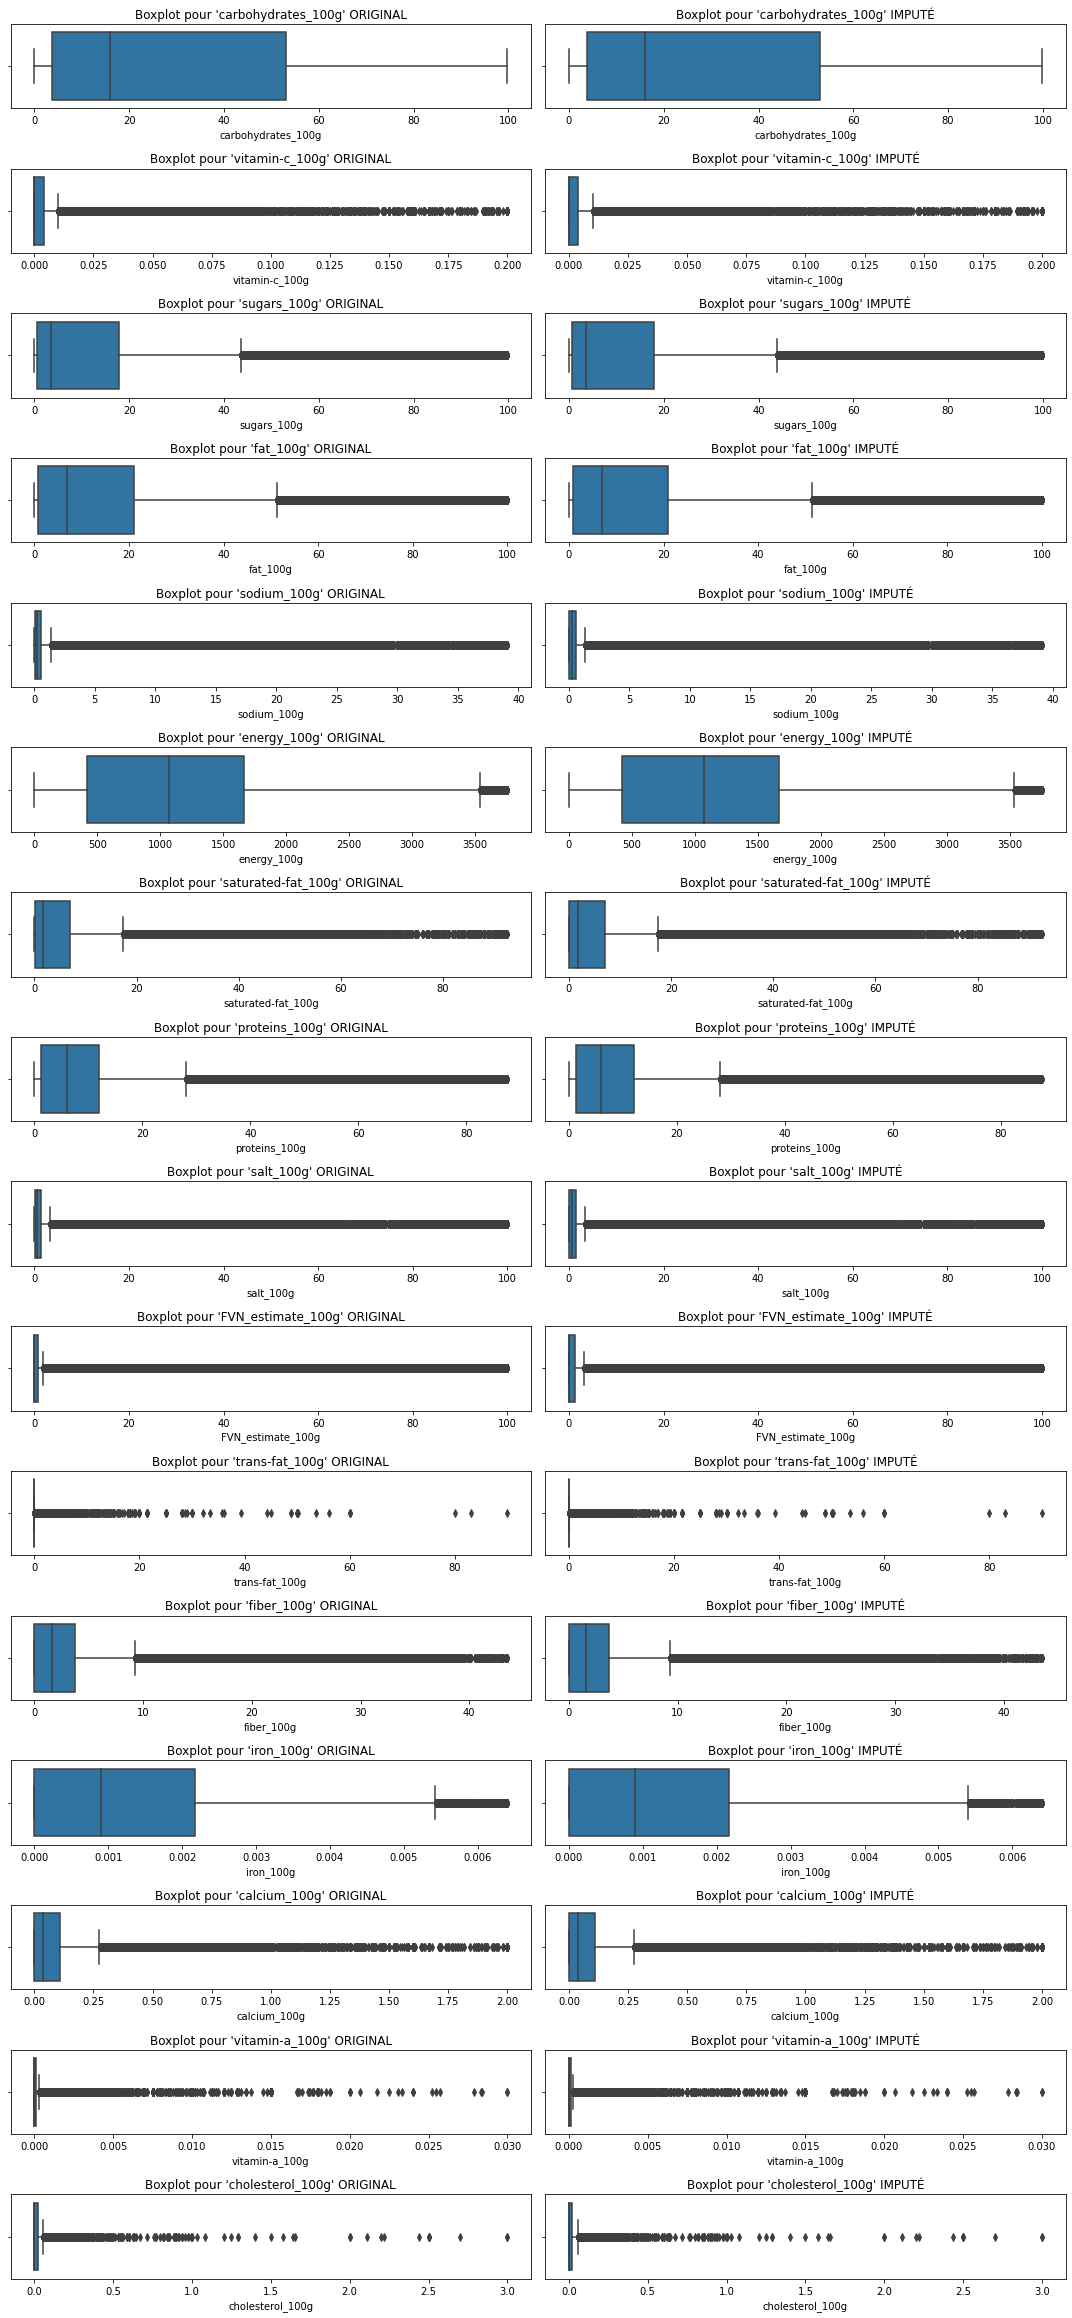

In [99]:
fig = plt.figure(figsize =(15, 60))

for i,v in enumerate(var_nutri):
    j= i*2
    ax = plt.subplot(30, 2, j+1)
    sns.boxplot(x=data_tmp[v][data_tmp[v].notnull()])
    plt.title(f"Boxplot pour '{v}' ORIGINAL")
    
    ax = plt.subplot(30, 2, j+2)
    sns.boxplot(x=data_imput_iter[v][data_tmp[v].notnull()])
    plt.title(f"Boxplot pour '{v}' IMPUTÉ")

fig.tight_layout()
plt.show()

> Il n'y a pas de différence significative.

#### Vérifions le remplissage des colonnes

In [100]:
fill_ratio = print_fill_rate(data_imput, var_nutri)

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
carbohydrates_100g |               0 |          100.00%
    vitamin-c_100g |               0 |          100.00%
       sugars_100g |               0 |          100.00%
          fat_100g |               0 |          100.00%
       sodium_100g |               0 |          100.00%
       energy_100g |               0 |          100.00%
saturated-fat_100g |               0 |          100.00%
     proteins_100g |               0 |          100.00%
         salt_100g |               0 |          100.00%
 FVN_estimate_100g |               0 |          100.00%
    trans-fat_100g |               0 |          100.00%
        fiber_100g |               0 |          100.00%
         iron_100g |               0 |          100.00%
      calcium_100g |               0 |          100.00%
    vitamin-a_100g |               0 |          

<AxesSubplot:>

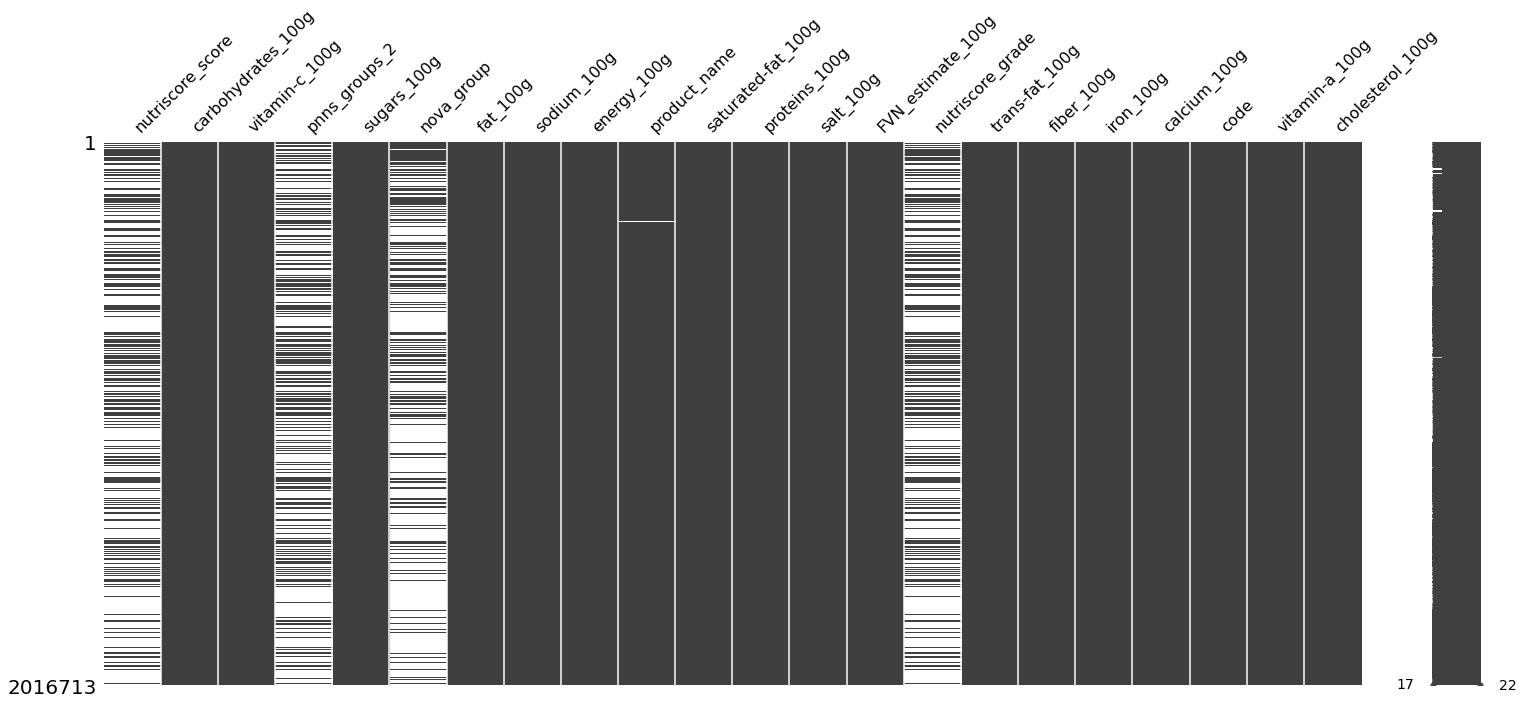

In [101]:
msno.matrix(data_imput)

#### Appliquons les imputations sur data_clean

In [102]:
data_clean = data_imput.copy()
data_clean.shape

(2016713, 22)

# 5. Démarche méthodologique d'analyse de données <a class="anchor" id="P05"></a>

## 5.1 Analyse univariée des variables <a class="anchor" id="analysis_univariate"></a>

Le but d'une analyse univariée est de décrire les données pour en découvrir les caractéristiques et mieux les comprendre. Pour ce faire, on examine la moyenne, le mode, la médiane, l'écart type, la dispersion, etc. par le biais d'histogrammes, de tableaux de distribution de fréquence, de diagrammes à barres, ou autres.

In [103]:
vars_quantitatives = data_nutri.select_dtypes(include=np.number).columns
vars_qualitatives = data_nutri.select_dtypes(exclude=np.number).columns

#### Mettons en place quelques fonctions qui vont nous aider dans le travail d'exploration et de nettoyage

In [104]:
# Définissons une fonction permettant d'explorer les colonnes numériques

def explore_quantitative(data, col_name):
    dt = data[col_name]
    print(dt.describe())
    
    fig = plt.figure(figsize =(15, 3))
    
    ax = plt.subplot(1, 2, 1)
    sns.boxplot(x=dt[dt.notnull()])
    plt.title(f"Boxplot for '{col_name}'")
    
    ax = plt.subplot(1, 2, 2)
    sns.kdeplot(dt, color='red')
    plt.title(f"Density plot for '{col_name}'")

In [105]:
# Définissons une fonction permettant d'afficher la répartition des données (sans pie-chart)

def display_fraction(data, col_name, title, ylabel="Remplissage (en %)", showscale=True, showtext=True):
    dt = data[col_name]

    fig = px.bar(dt, y=col_name, 
             #width=900,
             height=500,
             color=col_name, 
             title=title,
             labels={
                "fill_rate": ylabel,
                "index": "",
                },
             text_auto=showtext,
             template='ggplot2',
             #hover_data={'Fraction':':.2f'},
            )
    fig.update_coloraxes(showscale=showscale)
    fig.update_xaxes(tickangle = -45)
    fig.show()

In [106]:
# Définissons une finction permettant d'afficher quelques informations sur le remplissage d'UNE colonne

def show_missing(data, col_name):
    
    total_size = data.shape[0]
    total_size_nonull = data[col_name].notnull().sum()
    total_size_null = data[col_name].isnull().sum()
    percent_v = 100/total_size*total_size_null
    
    print(f"Il manque {total_size_null} sur {total_size} dans la colonne '{col_name}' ({percent_v:.2f}%)")
    
    fig = plt.figure(figsize=[15,5])

    plt.pie(list([total_size_null,total_size_nonull]), 
        labels=["", ""],
        autopct=lambda x: f"{x:.2f}%", shadow=False)
    plt.title(f"Répartition entre produits avec ou sans '{col_name}'")
    plt.legend([f"Produits sans '{col_name}'", f"Produits avec '{col_name}'"], loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

#### Commençons avec les variables qualitatives

---
### `code`

In [107]:
data_clean['code'].describe()

count               2016713
unique              2016713
top       00000000000000225
freq                      1
Name: code, dtype: object

#### Regardons le format des code-barres

In [108]:
data_clean['code'].unique()[:20]

array(['00000000000000225', '00000000000003429145', '0000000000017',
       '0000000000031', '000000000003327986', '000000000004622327',
       '00000000001', '0000000000100', '0000000000123', '0000000000178',
       '0000000000208', '0000000000284', '0000000000291', '000000000054',
       '000000000075', '000000000080', '000000000088', '0000000000949',
       '0000000000970', '0000000001001'], dtype=object)

#### Regardons le nombre de code-barres entièrement composés de chiffres *(donc sans lettres)*

In [109]:
digit_v = data_clean['code'].str.isdigit().sum()
percent_v = 100/data_clean.shape[0]*digit_v

print(f"Il y a {digit_v} code-barres entièrement composés de chiffres ({percent_v:.2f}%)")

Il y a 2016713 code-barres entièrement composés de chiffres (100.00%)


#### Regardons la répartition des code-barres en fonction de leur longueur

In [110]:
vcount = data_clean['code'].str.len().value_counts(dropna=True)
select_count = pd.DataFrame(vcount)

# On calcul le pourcentage
select_count = np.round(select_count / select_count.sum() * 100.0, 1)
select_count.rename(columns={'code':'Quantité'}, inplace=True)

# On selectionne les 25 premiers
select_count = select_count[:20]


display_fraction(select_count, 'Quantité', 
                 "Répartition des code-barres selon leur taille", 
                 showscale=True, showtext=True)

> On a donc 1 code-barre unique pour chaque ligne du jeu de données *(chaque code-barre est unique et aucun produit n'est pas de code-barre)*.
>
> Le format bien que toujours composé de chiffres, n'est pas un format unique *(on trouve des code de longueur 1 à 56)*. Cependant on constate que la grande majorité des `codes` sont au format [EAN-13](https://fr.wikipedia.org/wiki/Code-barres_EAN#Les_codes_EAN_13) *(92.9%).* puis  [EAN-8](https://fr.wikipedia.org/wiki/Code-barres_EAN#Les_codes_EAN_8) *(5.1%).*

> Nous avions gardé cette colonne pour aider à la suppression des doublons et c'est chose faite, elle ne présente donc plus d'autre intérêt que de rechercher un produit via son code-barre.
> 
> `Recommandations:` la colonne n'est d'aucune utilité pour le modèle prédictif, mais elle peut être utile pour retrouver un produit.

---
### `product_name`

In [111]:
data_clean['product_name'].describe()

count       2007675
unique      1385172
top       Ice cream
freq            719
Name: product_name, dtype: object

#### Regardons également la répartition de ces valeurs
Sachant que l'on a déjà supprimés les produits ayant le même nom ET les mêmes valeurs nutritionnelles, les produits restants avec un nom similaire sont donc des produits aux caractéristiques différentes.

In [112]:
data_clean['product_name'].value_counts(dropna=False)

None                                      9038
Ice cream                                  719
Spaghetti                                  711
Chocolat                                   708
Mozzarella                                 667
                                          ... 
Bonne Maman Black Cherry Conserve 370G       1
Bonne Maman Waldfrucht konfitüre             1
Confiture allégé Fraises                     1
P'tit dros                                   1
Signal Toothpaste                            1
Name: product_name, Length: 1385173, dtype: int64

In [113]:
vcount = data_clean['product_name'].value_counts(dropna=True)
select_count = pd.DataFrame(vcount)

# On calcul le pourcentage
#select_count = np.round(select_count / select_count.sum() * 100.0, 1)
select_count.rename(columns={'product_name':'Quantité'}, inplace=True)

# On selectionne les 25 premiers
select_count = select_count[:25]

display_fraction(select_count, 'Quantité', 
                 "Top 25 des noms de produits les plus communs", 
                 showscale=True, showtext=True)

#### Combien de produits ont un nom unique ?

In [114]:
unique_v = data_clean['product_name'].isin(vcount.index[vcount<=1.0]).sum()
percent_v = 100/data_clean.shape[0]*unique_v

print(f"Il y a {unique_v} noms de produits ne correspondant qu'à un seul produit ({percent_v:.2f}%)")

Il y a 1222558 noms de produits ne correspondant qu'à un seul produit (60.62%)


#### Et combien en manque-t-il ?

Il manque 9038 sur 2016713 dans la colonne 'product_name' (0.45%)


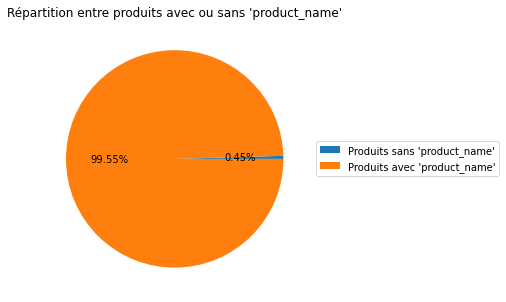

In [115]:
show_missing(data_clean, 'product_name')

> Si la majorité des produits sont uniques *(60.62%)*, de nombreux produits sont malgré tout associés au même nom. Ce n'est pas vraiment étonnant, car on peut avoir des noms très générique *(par exemple le mode est ici "Miel" avec 1449 instances)* avec des valeurs nutritionnelles différentes.
>
> On note d'ailleurs que malgré le nettoyage fait au préalable, il reste plus de 9000 produits sans nom...

> `Recommandations:` la colonne n'est d'aucune utilité pour le modèle prédictif, mais elle peut être utile pour retrouver un produit.

---
### `pnns_groups_2`

In [116]:
data_clean['pnns_groups_2'].describe()

count     753905
unique        41
top       Sweets
freq       69889
Name: pnns_groups_2, dtype: object

In [117]:
data_clean['pnns_groups_2'].value_counts(dropna=False)

None                                1262808
Sweets                                69889
Biscuits and cakes                    66747
Dressings and sauces                  52045
One-dish meals                        44640
Cheese                                43945
Cereals                               43508
Processed meat                        38643
Milk and yogurt                       33748
Vegetables                            30884
Fish and seafood                      28991
Meat                                  28034
Bread                                 24302
Sweetened beverages                   23430
Fats                                  20093
Alcoholic beverages                   16407
Fruits                                16171
Chocolate products                    16157
Salty and fatty products              14642
Appetizers                            12879
Unsweetened beverages                 11984
Breakfast cereals                     10682
Fruit juices                    

> On constate qu'il y a 41 super-catégories, qui ont chacune de 1 à 69889 produits.
>
> On note également la présence de 1262808 produits non catégorisés.

#### Affichons la répartition des catégories les plus fréquentes

In [118]:
select_count = pd.DataFrame(data_clean['pnns_groups_2'].value_counts(dropna=True))

# On calcul le pourcentage
select_count = np.round(select_count / select_count.sum() * 100.0, 1)
select_count.rename(columns={'pnns_groups_2':'Pourcentage'}, inplace=True)

# On selectionne les 25 premiers
select_count = select_count[:25]

display_fraction(select_count, 'Pourcentage', "Repartition (en % des non-nulls) de produits par catégories principales (Top 25 uniquement & hors None)", showscale=True, showtext=True)

> Les sucreries *(`Sweets`)*, biscuits et gateaux *(`Biscuits and cakes`)* prennent une place importante.
> 
> Les produits bruts comme la viande *(`Meat`)*, le poisson *(`Fish and seafood`)*, les légumes *(`Vegetables`)* ou les fruits *(`Fruits`)* sont moins bien représentés.

#### Enfin, vérifions combien de produits n'ont pas de valeur `pnns_groups_2`

Il manque 1262808 sur 2016713 dans la colonne 'pnns_groups_2' (62.62%)


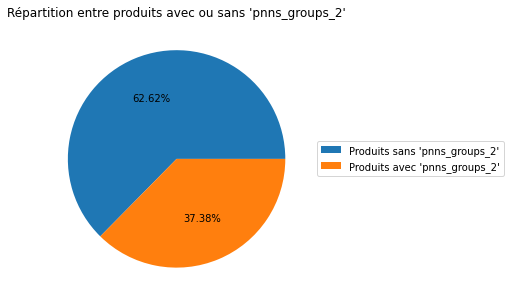

In [119]:
show_missing(data_clean, 'pnns_groups_2')

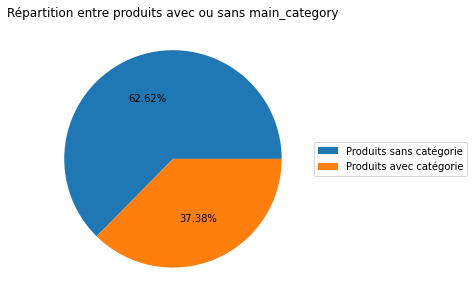

Il y a 1262808 produits non catégorisés (soit 62.62% des catégories)


In [120]:
total_size = data_clean.shape[0]
total_size_nonull = data_clean['pnns_groups_2'].count()
total_size_null = data_clean['pnns_groups_2'].isnull().sum()

fig = plt.figure(figsize=[15,5])

plt.pie(list([total_size_null,total_size_nonull]), 
        labels=["", ""],
        autopct=lambda x: f"{x:.2f}%", shadow=False)
plt.title("Répartition entre produits avec ou sans main_category")
plt.legend(["Produits sans catégorie", "Produits avec catégorie"], loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

percent_v = 100.0/total_size*total_size_null

print(f"Il y a {total_size_null} produits non catégorisés (soit {percent_v:.2f}% des catégories)")

> `Recommandation:` on peut essayer d'imputer cette colonne avec un KNN.

---
### `nova_group`

In [178]:
data_clean['nova_group'].describe()

count     643627
unique         4
top            4
freq      422738
Name: nova_group, dtype: object

In [179]:
data_clean['nova_group'].value_counts(dropna=False).sort_index()

1         67888
2         25630
3        127371
4        422738
None    1373086
Name: nova_group, dtype: int64

#### Affichons la répartition des nova_groups

In [181]:
vcount = data_clean['nova_group'].value_counts(dropna=True).sort_index()
select_count = pd.DataFrame(vcount)

# On calcul le pourcentage
select_count = np.round(select_count / select_count.sum() * 100.0, 1)
select_count.rename(columns={'nova_group':'Pourcentage'}, inplace=True)

display_fraction(select_count, 'Pourcentage', 
                 "Repartition des Nova-groups (sur les valeurs non-nulles)", 
                 showscale=True, showtext=True)

#### Enfin, vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 1373086 sur 2016713 dans la colonne 'nova_group' (68.09%)


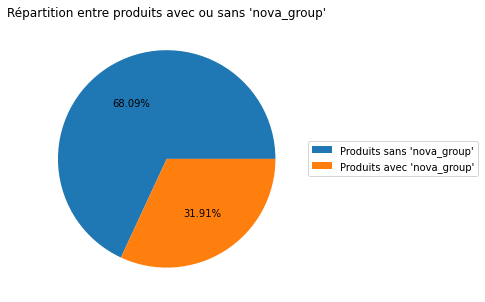

In [182]:
show_missing(data_clean, 'nova_group')

> D'après la [documentation sur les nova-groups](https://fr.openfoodfacts.org/nova), les groupes possibles sont les suivants :
> - Groupe 1 - Aliments non transformés ou transformés minimalement
> - Groupe 2 - Ingrédients culinaires transformés
> - Groupe 3 - Aliments transformés
> - Groupe 4 - Produits alimentaires et boissons ultra-transformés

> On constate donc une large majorité de produits du **Groupe 4** *(65.7%%)* contre une représentation bien plus petite des trois autres groupes.

> `Recommandation:` explorer la relation entre `nova_group` et les colonnes nutritionnelles ou les colonnes de `nutriscore` lors des analyses multivariées.

---
### `nutriscore_grade`

In [121]:
data_clean['nutriscore_grade'] = data_clean['nutriscore_grade'].str.upper()

In [122]:
data_clean['nutriscore_grade'].describe()

count     738428
unique         5
top            D
freq      226842
Name: nutriscore_grade, dtype: object

In [123]:
data_clean['nutriscore_grade'].value_counts(dropna=False).sort_index()

A        116223
B         98506
C        159126
D        226842
E        137731
None    1278285
Name: nutriscore_grade, dtype: int64

#### Affichons la répartition des nutriscore_grades

In [124]:
vcount = data_clean['nutriscore_grade'].value_counts(dropna=True).sort_index()
select_count = pd.DataFrame(vcount)

# On calcul le pourcentage
select_count = np.round(select_count / select_count.sum() * 100.0, 1)
select_count.rename(columns={'nutriscore_grade':'Pourcentage'}, inplace=True)

display_fraction(select_count, 'Pourcentage', 
                 "Repartition des Nutri-grades (sur les valeurs non-nulles)", 
                 showscale=True, showtext=True)

#### Enfin, vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 1278285 sur 2016713 dans la colonne 'nutriscore_grade' (63.38%)


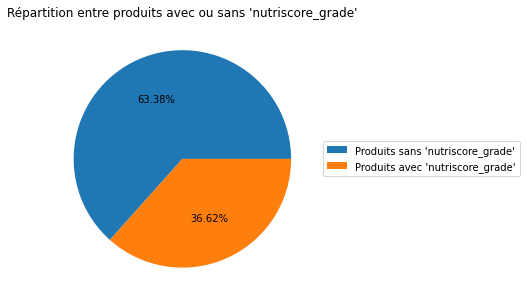

In [125]:
show_missing(data_clean, 'nutriscore_grade')

> Si la majorité des grades ne sont pas renseignés *(63.38%)*, on constate quand ils le sont beaucoup de **D** *(30.7%)*, peu de **B** *(13.3%)* et modèrement du reste (**A**: 15.7%, **C**: 21.5%, **E**: 18.7%).
>
> Il est très probable que l'on retrouve une répartition similaire dans la colonne `nutriscore_score` *(c'est juste après)*.

> `Recommandation:` explorer la relation entre `nutriscore_score` et `nutriscore_grade` lors des analyses multivariées.

#### A présent regardons les variables quantitatives

---
### `nutriscore_score

count   738428.000
mean         9.126
std          8.852
min        -15.000
25%          1.000
50%         10.000
75%         16.000
max         40.000
Name: nutriscore_score, dtype: float64


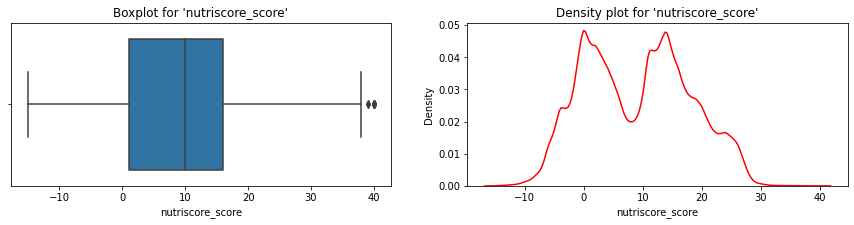

In [126]:
explore_quantitative(data_clean, 'nutriscore_score')

#### Et vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 1278285 sur 2016713 dans la colonne 'nutriscore_score' (63.38%)


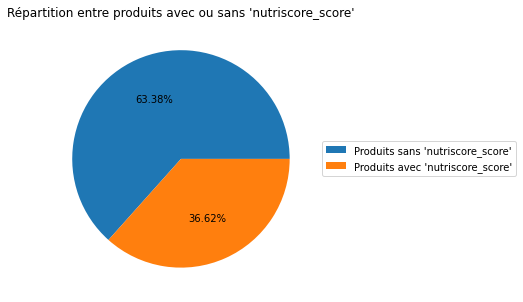

In [127]:
show_missing(data_clean, 'nutriscore_score')

> Les valeurs s'étalent de -15 à 40 avec deux pics de densité autour de 0 et 15.
>
> D'après la documentation nutriscore, on doit avoir des scores allant de -15 à 40. Et c'est exactement ce que nous avons.
>
> Par ailleurs deux sommets sur le graphique de densité qui semblent correspondre aux nutrigrade B et D. *(voir [P34](https://www.santepubliquefrance.fr/content/download/150262/file/2021_07_21_QR_scientifique_et_technique_V42_VFR.pdf))*.<br> On peut donc supposer qu'il y a:
> - une quantité **moderée** de produits classés **A** [-15;-1]
> - une **petite** quantité de produits classés **B** [0;2] (car l'intervalle est très petit)
> - une quantité **moderée** de produits classés **C** [3;10]
> - une **grande** quantité de produits classés **D** [11;18]
> - une quantité **moderée** de produits classés **E** [18;40]
>
> La réparition constaté dans l'analyse univariée de `nutriscore_grade` se retrouve également dans la colonne `nutriscore_score`, et on observe également que le nombre de valeurs manquantes est exactement le même.
>
> Enfin, on note que la distribution n'est **pas `normale`**.


> `Recommandation:` explorer la relation entre `nutriscore_score` et `nutriscore_grade` lors des analyses multivariées.

---
### `saturated-fat_100g`

count   2016713.000
mean          4.806
std           6.929
min           0.000
25%           0.200
50%           2.780
75%           5.360
max          92.600
Name: saturated-fat_100g, dtype: float64


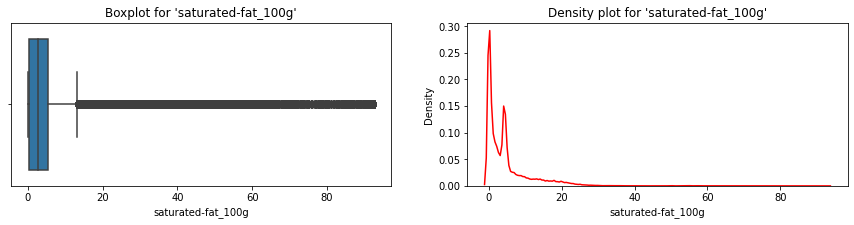

In [128]:
explore_quantitative(data_clean, 'saturated-fat_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 2016713 dans la colonne 'saturated-fat_100g' (0.00%)


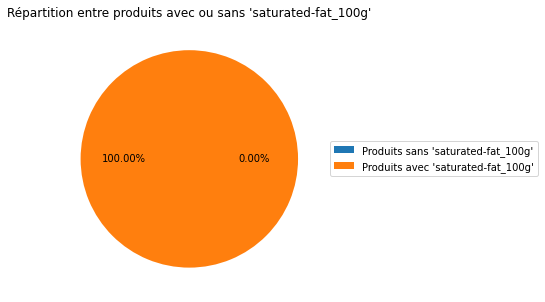

In [129]:
show_missing(data_clean, 'saturated-fat_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `trans-fat_100g`

count   2016713.000
mean          0.048
std           0.267
min           0.000
25%           0.012
50%           0.035
75%           0.051
max          90.000
Name: trans-fat_100g, dtype: float64


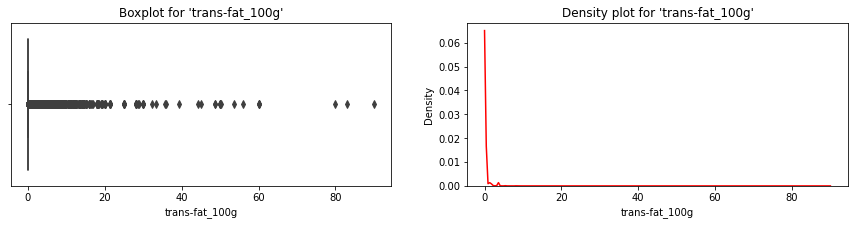

In [130]:
explore_quantitative(data_clean, 'trans-fat_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 2016713 dans la colonne 'trans-fat_100g' (0.00%)


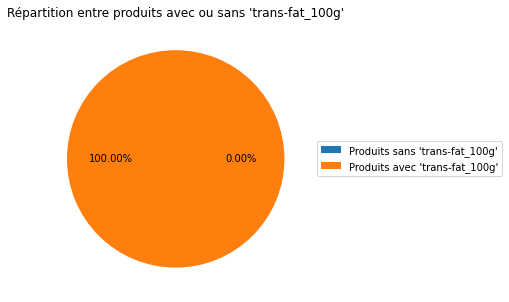

In [131]:
show_missing(data_clean, 'trans-fat_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `cholesterol_100g`

count   2016713.000
mean          0.022
std           0.025
min           0.000
25%           0.006
50%           0.017
75%           0.027
max           3.000
Name: cholesterol_100g, dtype: float64


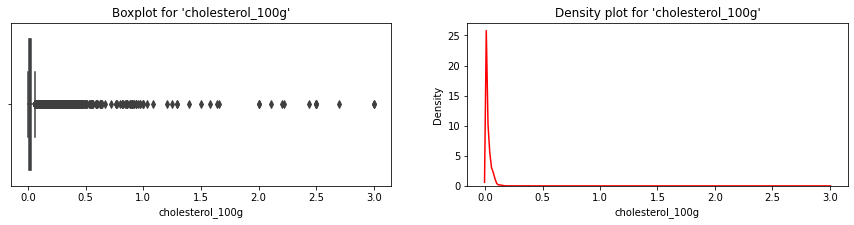

In [132]:
explore_quantitative(data_clean, 'cholesterol_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 2016713 dans la colonne 'cholesterol_100g' (0.00%)


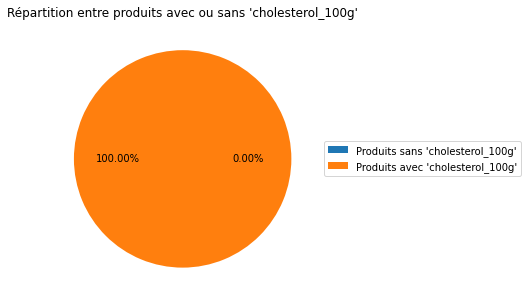

In [133]:
show_missing(data_clean, 'cholesterol_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `fat_100g`

count   2016713.000
mean         13.399
std          16.005
min           0.000
25%           1.300
50%          10.100
75%          18.000
max         100.000
Name: fat_100g, dtype: float64


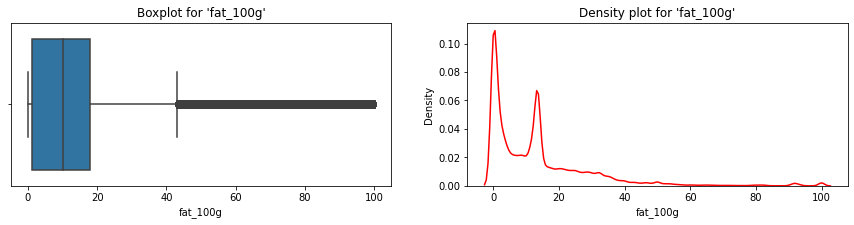

In [134]:
explore_quantitative(data_clean, 'fat_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 2016713 dans la colonne 'fat_100g' (0.00%)


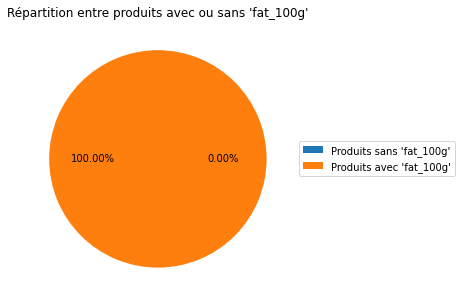

In [135]:
show_missing(data_clean, 'fat_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `sugars_100g`

count   2016713.000
mean         12.959
std          17.432
min           0.000
25%           1.000
50%           5.880
75%          13.787
max          99.800
Name: sugars_100g, dtype: float64


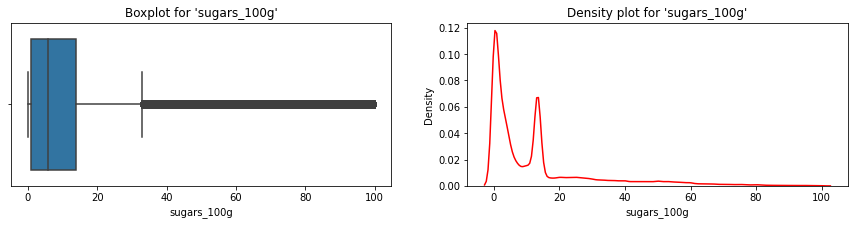

In [136]:
explore_quantitative(data_clean, 'sugars_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 2016713 dans la colonne 'sugars_100g' (0.00%)


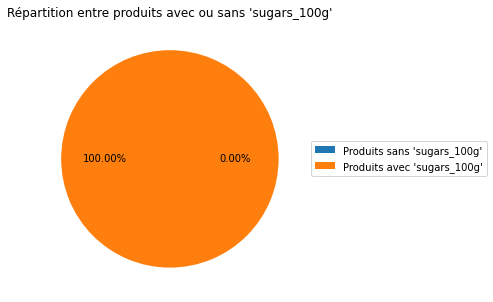

In [137]:
show_missing(data_clean, 'sugars_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `carbohydrates_100g`

count   2016713.000
mean         28.441
std          25.500
min           0.000
25%           5.100
50%          25.500
75%          48.000
max          99.800
Name: carbohydrates_100g, dtype: float64


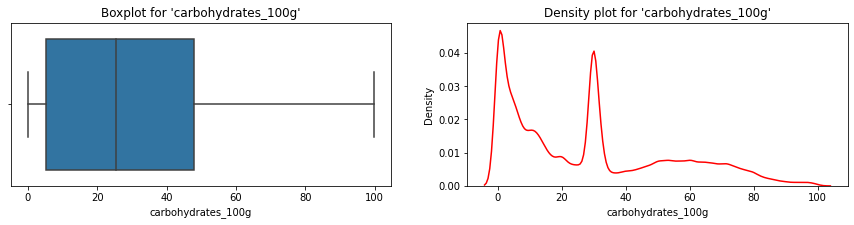

In [138]:
explore_quantitative(data_clean, 'carbohydrates_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 2016713 dans la colonne 'carbohydrates_100g' (0.00%)


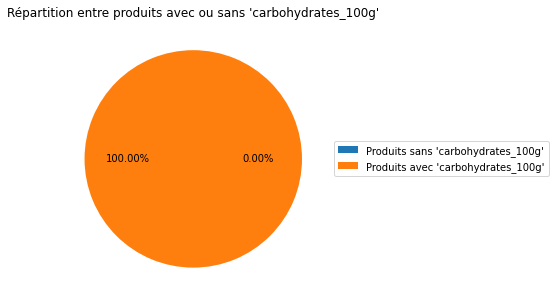

In [139]:
show_missing(data_clean, 'carbohydrates_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `salt_100g`

count   2016713.000
mean          1.373
std           4.113
min           0.000
25%           0.130
50%           1.000
75%           1.391
max         100.000
Name: salt_100g, dtype: float64


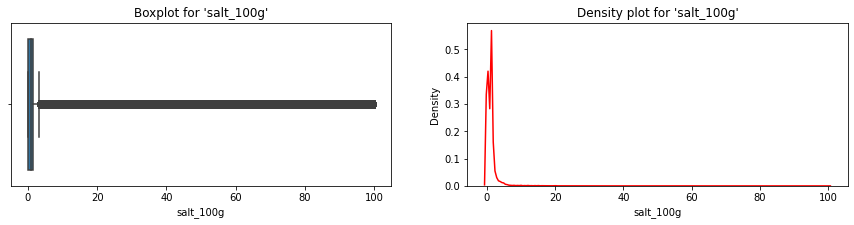

In [140]:
explore_quantitative(data_clean, 'salt_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 2016713 dans la colonne 'salt_100g' (0.00%)


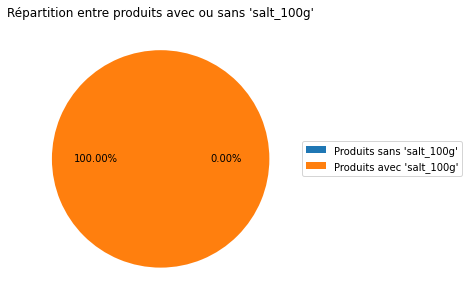

In [141]:
show_missing(data_clean, 'salt_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `sodium_100g`

count   2016713.000
mean          0.549
std           1.637
min           0.000
25%           0.052
50%           0.400
75%           0.556
max          39.100
Name: sodium_100g, dtype: float64


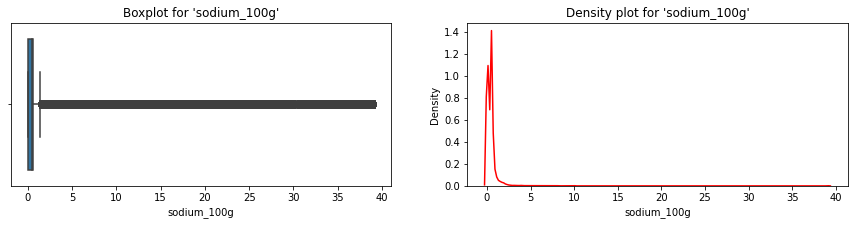

In [142]:
explore_quantitative(data_clean, 'sodium_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 2016713 dans la colonne 'sodium_100g' (0.00%)


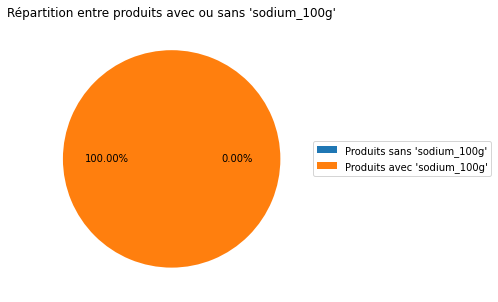

In [143]:
show_missing(data_clean, 'sodium_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `calcium_100g`

count   2016713.000
mean          0.107
std           0.113
min           0.000
25%           0.035
50%           0.088
75%           0.133
max           2.000
Name: calcium_100g, dtype: float64


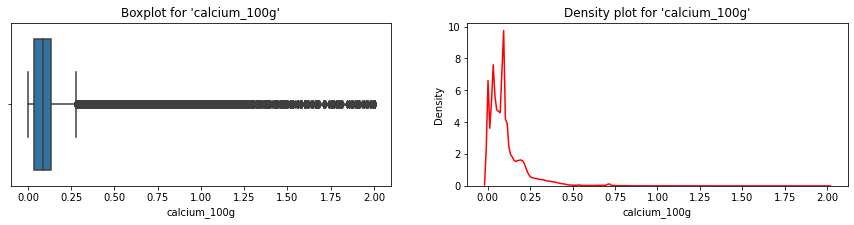

In [144]:
explore_quantitative(data_clean, 'calcium_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 2016713 dans la colonne 'calcium_100g' (0.00%)


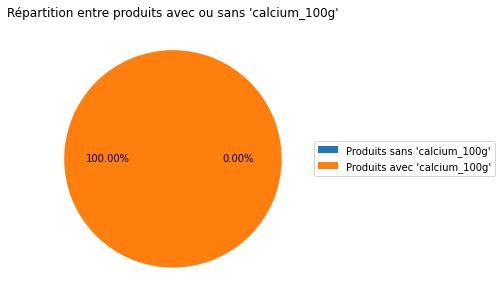

In [145]:
show_missing(data_clean, 'calcium_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `proteins_100g`

count   2016713.000
mean          8.421
std           9.010
min           0.000
25%           2.200
50%           7.198
75%          10.400
max          87.600
Name: proteins_100g, dtype: float64


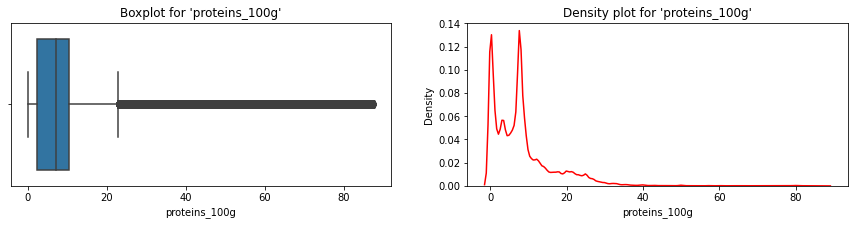

In [146]:
explore_quantitative(data_clean, 'proteins_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 2016713 dans la colonne 'proteins_100g' (0.00%)


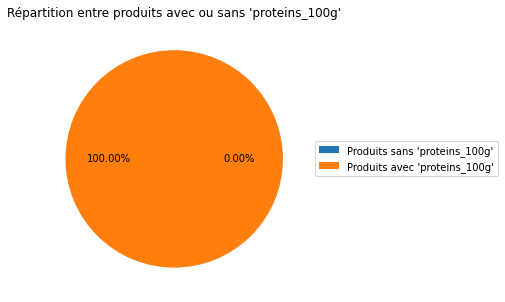

In [147]:
show_missing(data_clean, 'proteins_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `fiber_100g`

count   2016713.000
mean          2.828
std           2.853
min           0.000
25%           1.119
50%           2.608
75%           3.500
max          43.500
Name: fiber_100g, dtype: float64


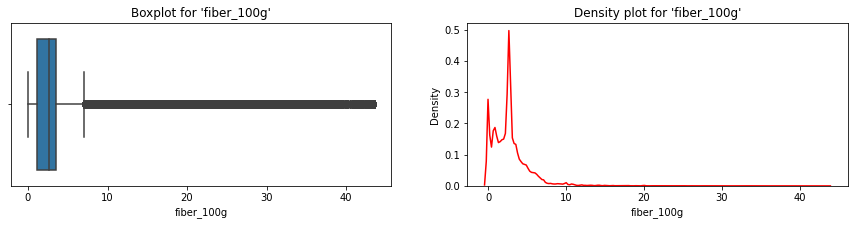

In [164]:
explore_quantitative(data_clean, 'fiber_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 2016713 dans la colonne 'fiber_100g' (0.00%)


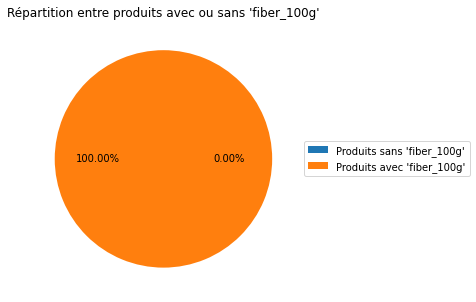

In [151]:
show_missing(data_clean, 'fiber_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `FVN_estimate_100g`

count   2016713.000
mean          8.746
std          13.993
min           0.000
25%           0.000
50%           7.326
75%          11.489
max         100.000
Name: FVN_estimate_100g, dtype: float64


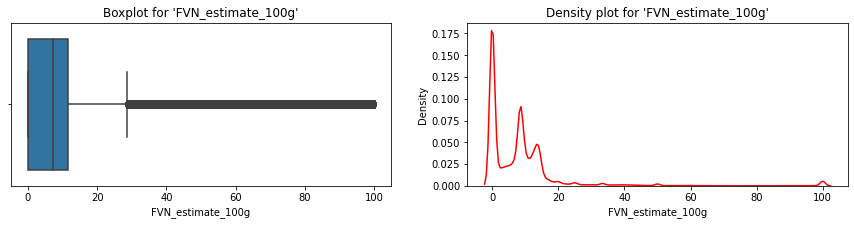

In [152]:
explore_quantitative(data_clean, 'FVN_estimate_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

In [163]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Il manque 0 sur 2016713 dans la colonne 'FVN_estimate_100g' (0.00%)


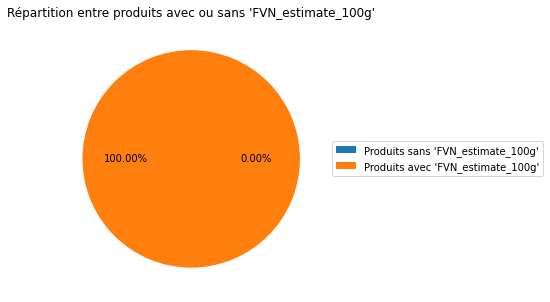

In [153]:
show_missing(data_clean, 'FVN_estimate_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `iron_100g`

In [161]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

count   2016713.00000
mean          0.00126
std           0.00088
min           0.00000
25%           0.00061
50%           0.00126
75%           0.00161
max           0.00640
Name: iron_100g, dtype: float64


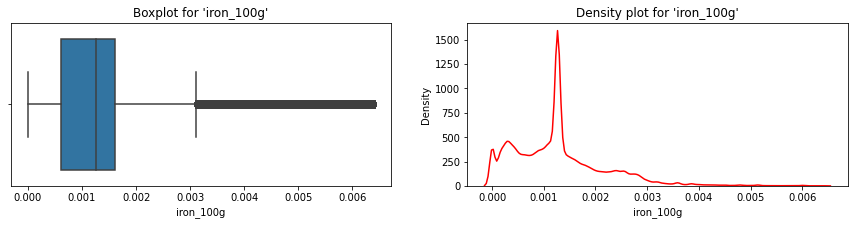

In [162]:
explore_quantitative(data_clean, 'iron_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 2016713 dans la colonne 'iron_100g' (0.00%)


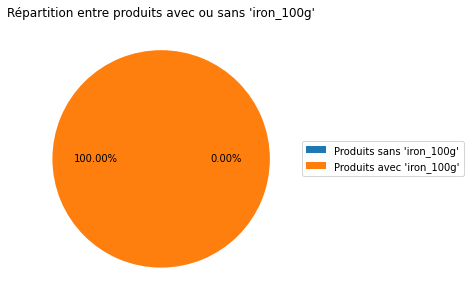

In [149]:
show_missing(data_clean, 'iron_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `vitamin-a_100g`

In [165]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

count   2016713.00000
mean          0.00022
std           0.00029
min           0.00000
25%           0.00011
50%           0.00017
75%           0.00025
max           0.03000
Name: vitamin-a_100g, dtype: float64


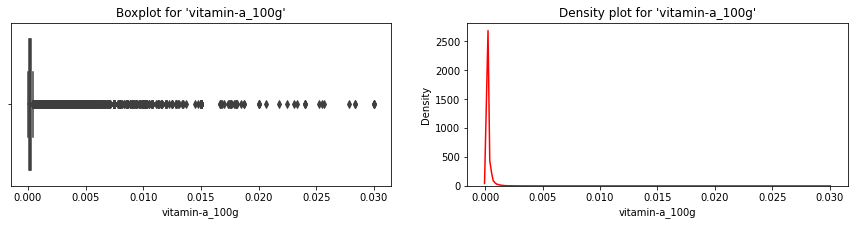

In [166]:
explore_quantitative(data_clean, 'vitamin-a_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 2016713 dans la colonne 'vitamin-a_100g' (0.00%)


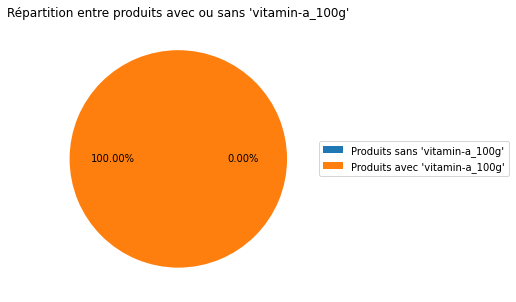

In [160]:
show_missing(data_clean, 'vitamin-a_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

In [156]:
STOP

NameError: name 'STOP' is not defined

---
### `vitamin-c_100g`

> On note que cette variable présente de nombreuses valeurs atypiques. <br>Le max est à 100g et c'est de toutes évidences une valeur aberrantes, mais je n'ai pas réussi à trouver le plus haut taux de vitamine-a dans un aliment de façon certaine.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

In [167]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

count   2016713.00000
mean          0.00726
std           0.00711
min           0.00000
25%           0.00421
50%           0.00666
75%           0.00929
max           0.20000
Name: vitamin-c_100g, dtype: float64


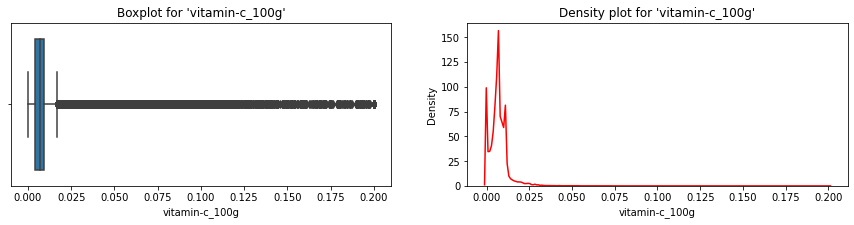

In [168]:
explore_quantitative(data_clean, 'vitamin-c_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 2016713 dans la colonne 'vitamin-c_100g' (0.00%)


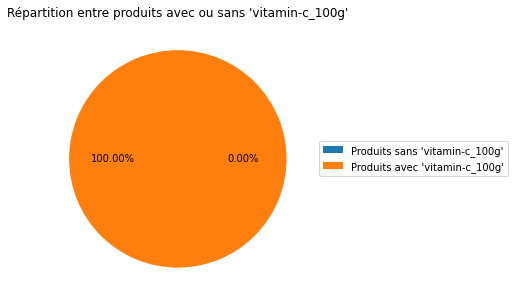

In [169]:
show_missing(data_clean, 'vitamin-c_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

---
### `energy_100g`

In [174]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

count   2016713.00
mean       1123.05
std         731.55
min           0.00
25%         515.00
50%        1119.09
75%        1577.00
max        3756.60
Name: energy_100g, dtype: float64


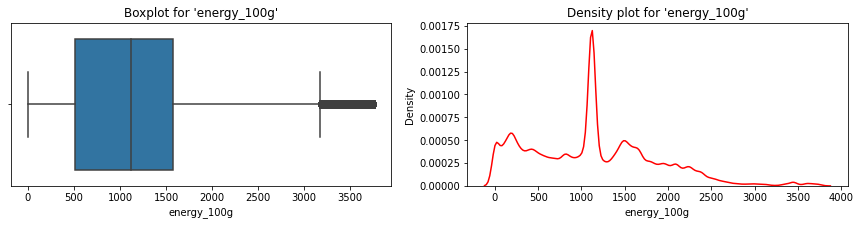

In [175]:
explore_quantitative(data_clean, 'energy_100g')

#### Vérifions combien de produits n'ont pas de valeur dans cette colonne

Il manque 0 sur 2016713 dans la colonne 'energy_100g' (0.00%)


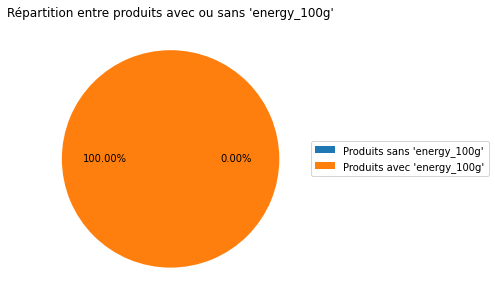

In [176]:
show_missing(data_clean, 'energy_100g')

> On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.
>
> Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.
>
> Enfin, on note que la distribution n'est **pas `normale`**.

> `Recommandation:` faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.

## 5.2 Analyse multivariée <a class="anchor" id="analysis_multivariate"></a>

Les analyses multivariées ont pour vocation de mettre en évidence des informations sur les relations entre variables. Mais sans objectif on peut croiser beaucoup de données sans vraiment savoir ce que l'on cherche...

Voici donc les objectifs pour lesquels il serait utile d'avoir des informations:
1. Vérifier la relation entre `nutriscore_score` et les divers indicateurs des nutriments.
2. Vérifier la relation entre `nutriscore_grade` et les divers indicateurs des nutriments.
3. Vérifier la relation entre `nutriscore_score` et `nutriscore_grade`
4. Vérifier la relation entre `nutriscore_grade` et `pnns_groups_2`

---

### Commençons par vérifier si l'ensemble des colonnes des `_100g` ne dépassent pas 100g

In [ ]:
data_check = data_clean.copy()

# Afin de pouvoir faire des sommes, je remplace les None par 0
data_check[data_check.select_dtypes(include=np.number).columns] = data_check[data_check.select_dtypes(include=np.number).columns].fillna(0)

In [ ]:
data_check.shape

#### On vérifie que la sommes des principales familles de nutriments ne dépasse pas 100g.

In [ ]:
data_check[
        data_check['saturated-fat_100g'] + \
        data_check['fiber_100g'] + \
        data_check['proteins_100g'] + \
        data_check['sugars_100g'] + \
        data_check['salt_100g'] > 100
    ][[
        'product_name',
        'saturated-fat_100g', 
        'fiber_100g',
        'proteins_100g', 
        'sugars_100g', 
        'salt_100g', 
        'FVN_estimate_100g'
    ]]

> On a donc 665 produits pour lesquels la sommes des principaux indicateurs de nutriments dépasse 100g.
>
> En regardant de plus près, on découvre des valeurs qui n'ont pas vraiment de sens. Comme des `tomates` avec 88g de graisse saturée et 72g de protéines, ou encore `des livres` d'économie ou de droit en italien...
>
> La quantité de produits concernés étant assez restreint, le mieux est de les supprimer.

In [ ]:
data_clean.shape

In [ ]:
data_clean = data_check[
        data_check['saturated-fat_100g'] + \
        data_check['fiber_100g'] + \
        data_check['proteins_100g'] + \
        data_check['sugars_100g'] + \
        data_check['salt_100g'] <= 100
].copy()
data_clean.shape

### Ensuite vérifions les indices de corrélation entre les variables numériques. <a class="anchor" id="P03_correlation_num"></a>

Il existe plusieurs types de relations entre des variables numériques. Par exemple les rélations linéaires ou encore les relations monotones.
- Dans une relation linéaire, les variables se déplacent dans la même direction à un rythme constant.
- Dans une relation monotone, les variables ont tendance à se déplacer dans la même direction relative, mais pas nécessairement à un rythme constant.


Pour ces deux mesures les valeurs peuvent aller de -1 à 1 (inclus):
- -1 indique une relation forte dans le sens inverse (corrélation négative)
- +1 indique une relation forte dans le même sens (corrélation positive)
- 0  indique qu'il n'y a pas de relation.

Calculons donc les deux pour voir si quelque chose s'en dégage.

In [ ]:
fig = plt.figure(figsize=(19,5))

plt.subplot(1,2,1)
corr= data_clean.corr(method="pearson")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Pearson (lineaire)')
ax.legend

plt.subplot(1,2,2)
corr= data_clean.corr(method="spearman")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Spearman (monotonic)')

plt.show()

# A REFAIRE (les données ont changées)
> Si l'on s'intéresse à la colonne **`nutriscore_score`**, on remarque qu'elle est **corrélée à divers degrès avec toutes les colonnes** sauf `proteins_100g`. C'est plutôt une bonne nouvelle, car hormis `proteins_100g`, on devrait pouvoir s'appuyer sur ces colonnes pour essayer de prédire le score et donc le grade.
> 
> Le sens des corrélations constatées est d'ailleurs raccord avec ce que l'on était en droit d'espèrer d'après la documentation du Nutriscore; une corrélation positive pour `saturated-fat_100g`, `sugars_100g`, `salt_100g`, `energy_100g` et une corrélation négative pour `fiber_100g`, `FNV_estimate_100g`, `proteins_100g` *(puisque plus le `nutriscore_score` est grand moins c'est favorable et inversement plus il est bas et plus c'est favorable)*.

> On note que globalement, la plupart des éléments nutritifs présents dans ce tableau sont corrélés à divers degrés avec les autres éléments. Il y a finalement assez peu de relation neutres (`nutriscore_score` avec `proteins_100g`, `fiber_100g` avec `salt_100g`, `sugars_100g` avec `FVN_estimate_100g` ou `saturated-fat_100g`)...

---

#### Vérifions les relations entre `nutriscore_score` et les autres variables numériques
avec des `régressions linéaires` et le `coéfficient de détermination R²`

Pour le coéfficient de détermination R², les valeurs peuvent aller de 0 à 1 (inclus):
- 1 indique une relation forte.
- 0  indique qu'il n'y a pas de relation.


In [ ]:
columns_ = ['saturated-fat_100g', 'salt_100g', 'sugars_100g', 'proteins_100g', 'fiber_100g', 'FVN_estimate_100g', 'energy_100g']
data_sample = data_clean.sample(frac=0.1, random_state=0).copy()
data_sample.dropna(inplace=True)

In [ ]:
from scipy import stats

fig = plt.figure(figsize=(19,15))

for i, col in enumerate(columns_):
    plt.subplot(4,2,i+1)

    slope, intercept, r_value, pv, se = stats.linregress(data_sample['nutriscore_score'], data_sample[col])
    sns.regplot(x="nutriscore_score", y=col, data=data_sample, line_kws={'label':f"y={slope:.2f}x + {intercept:.2f}    [R²={r_value**2:.2f}]"})
    #sns.jointplot(x="nutriscore_score", y=col, data=data_clean.sample(frac=0.01), kind="reg")#, stat_func=r2)
    plt.title(f"Regplot for {col}")
    plt.legend()

fig.tight_layout()
plt.show()

> En regardant les coéfficients de déterminations R², on constate exactement les même tendances qu'avec les coefficients de Pearson et Spearman. On a une corrélation moyennement forte pour `saturated-fat_100g`, `energy_100g` et `sugars_100g`, une corrélation faible pour `salt_100g`, `FVN_estimate_100g` et `fiber_100g`, aucune corrélation pour `proteins_100g`.
>
> - `saturated-fat_100g`: **R² = 0.40** *[Pearson = 0.58 & Spearman = 0.64]*
> - `energy_100g`:        **R² = 0.37** *[Pearson = 0.55 & Spearman = 0.60]*
> - `sugars_100g`:        **R² = 0.29** *[Pearson = 0.43 & Spearman = 0.32]*
> - `salt_100g`:          **R² = 0.09** *[Pearson = 0.31 & Spearman = 0.31]*
> - `FVN_estimate_100g`:  **R² = 0.08** *[Pearson = -0.24 & Spearman = -0.19]*
> - `fiber_100g`:         **R² = 0.03** *[Pearson = -0.17 & Spearman = -0.21]*
> - `proteins_100g`:      **R² = 0.00** *[Pearson = 0.08 & Spearman = 0.08]*

> Même si l'on retrouve des tendances similaires à ce que l'on a observé avec `nutriscore_score`, on constate que les relations entre les indicateurs des nutriments et le `nutriscore_grade` sont encore une fois moins évidentes.

> A ce stade, il parait donc opportun de travailler sur la prédiction du `nutriscore_score` et de le convertir en `nutriscore_grade` plutôt que de directement chercher à prédire `nutriscore_grade`.

### Puis vérifions les indices de corrélation entre les variables numériques et nominales.
                                                                                   
Pour permettre de vérifier simplement la corrélation entre les variables numériques et les variables nominales, nous allons utiliser un LabelEncoder sur les colonnes nominales qui nous intéressent puis calculer à nouveau les corrélations linéaires et monotones.<br>(On pourrait aussi calculer $\eta^2$ à partir d'une ANOVA)

In [ ]:
data_corr = data_clean.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
cats = ['pnns_groups_2', 'nutriscore_grade', 'nova_group']

for cat in cats:
    encoder=LabelEncoder()
    encoder.fit(data_corr[cat])
    data_corr[f"{cat}_enc"]=encoder.transform(data_corr[cat])

In [ ]:
fig = plt.figure(figsize=(19,5))

plt.subplot(1,2,1)
corr= data_corr.corr(method="pearson")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Pearson (lineaire)')
ax.legend

plt.subplot(1,2,2)
corr= data_corr.corr(method="spearman")
matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Spearman (monotonic)')
#ax.set(yticklabels=[x[-22:] for x in data_corr.select_dtypes(include=np.number).columns])

plt.show()

> Comme attendu on constate une forte corrélation entre le `nutriscore_score` et `nutriscore_grade_enc`.
>
> On constate également plusieurs corrélations entre `nutriscore_grade_enc` et les divers indicateurs nutritionnels, mais elles sont nettement moins prononcées qu'avec `nutriscore_score`.
>
> Enfin, les deux autres variables nominales encodées `nova_group_enc` et `pnns_groups_2_enc` ne semblent pas particulièrement sensible aux variables des nutriments.
---

#### Vérifions les relations entre `nutriscore_grade` et les variables des nutriments

In [ ]:
from scipy import stats

columns_ = ['saturated-fat_100g', 'salt_100g', 'sugars_100g', 'proteins_100g', 'fiber_100g', 'FVN_estimate_100g', 'energy_100g', 'nutriscore_score']

fig = plt.figure(figsize=(19,25))

for i, col in enumerate(columns_):
    plt.subplot(4,2,i+1)
    sns.boxplot(data=data_clean, x='nutriscore_grade', y=col, order='abcde')
    plt.title(f"Boxplot for {col}")

fig.tight_layout()
plt.show()

> Pour le boxplot `nutriscore_score` vs `nutriscore_grade` on perçoit immédiatement une relation forte.
>
> La documentation indique les plages suivantes pour les aliments:
> - [-15;-1] pour le **A**
> - [0;2] pour le **B**
> - [3;10] pour le **C**
> - [11;18] pour le **D**
> - [19;40] pour le **E**
>
> La documentation indique les plages suivantes pour les boissons:
> - Uniquement l'eau pour le **A**
> - [-15;1] pour le **B**
> - [2;5] pour le **C**
> - [6;9] pour le **D**
> - [10;40] pour le **E**
>
> On remarque des outliers, mais on constate que ces valeurs semblent majoritairement respectées.

> En revanche pour la relation de `nutriscore_grade` avec les autres indicateurs les tendances sont présentes, *(comme on vient de le voir avec les corrélation de Pearson et Spearman)* mais nettement moins prononcées qu'avec `nutriscore_score`.

### Enfin vérifions les indices de corrélation entre les variables nominales. <a class="anchor" id="P03_correlation_nom"></a>

Pour ce faire, nous allons utiliser le test V de Cramer.<br>
C'est une mesure d'association entre deux variables nominales, qui est basée sur le Chi-squared de Pearson.<br>
Elle donne une valeur comprise entre 0 et +1 (inclus)
- 0 : il n'y a visiblement aucune relation entre les variables.
- 1 : il y a une relation parfaite entre les variables (on ne peut atteindre 1 que lorsque chaque variable est complètement déterminée par l'autre).

In [ ]:
import scipy.stats as ss

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

vars_ = ['nutriscore_grade', 'nova_group', 'pnns_groups_2']

corr = []
for v1 in vars_:
    corr2 = []
    for v2 in vars_:
        confusion_matrix = pd.crosstab(data[v1], data[v2])
        cramer_score = cramers_v(confusion_matrix.values)
        #print(f"{v1} / {v2} -> {cramer_score}")
        corr2.append(cramer_score)
    corr.append(corr2)
    
corr = pd.DataFrame(corr)
corr.index = corr.columns = vars_

In [ ]:
fig = plt.figure(figsize=(19,5))

matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=0, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Cramer V entre les 2 variables nominales')

plt.show()

> Le `nutriscore_grade` n'est que peu corrélé au `nova_group`, mais on constate en revanche que ces deux systèmes de classifications sont assez corrélés aux catégories de produits `pnns_groups_2`.

### Regardons également les relations `pnns_groups_2` vs `nutriscore_score` et `nutriscore_grade`

#### Comment se répartissent les catégories `pnns_groups_2` sur les différents grade de `nutriscore_grade` ?

In [ ]:
num_cats = 25
top_categories = list(data_clean['pnns_groups_2'].value_counts(dropna=True)[:num_cats].index)

#--- prepare data
#data_tmp = data_clean.copy()
#data_tmp['category'] = data_tmp['pnns_groups_2']
#data_tmp.loc[~data_tmp['pnns_groups_2'].isin(top_categories),'category'] = 'OTHERS'
#top_categories.append('OTHERS')

#--- select data
selection = data_clean.groupby(['nutriscore_grade', 'pnns_groups_2']).size().reset_index()
selection.rename(columns={0:'count'}, inplace=True)
data_graph = selection[selection['pnns_groups_2'].isin(top_categories)]

#--- graph
fig = px.bar(data_graph, 
             x="nutriscore_grade",
             y="count",
             color="pnns_groups_2",
             title=f"Répartition des produits des {num_cats} catégories principales dans les Nutri-grades",
             labels={'count': 'Nombre de produits', 'nutriscore_grade':'Nutri-grade', 'pnns_groups_2':'Categories'},
             category_orders={'nutriscore_grade': ['a','b','c','d','e']},
             height=700,
            )
fig.show()

> Le `grade A` semble contenir des **aliments bruts**; *légumes*, *céréales*, *fruits*, *viandes*, *poissons* et *produits laitiers*. Mais aussi **quelques produits transformés** comme des *plats-cuisinés* et *sucreries* qui sont plus surprenants.

> Le `grade B` semble contenir des **aliments bruts** et des **produits transformés**; *plats-cuisinés*, *produits-laitiers*, *viandes*, *poissons*, *céréales**, *pains*...

> Le `grade C` semble contenir des **produits bruts gras** et des **produits transformés**; *plats-cuisinés*, *huiles*, *sauces*, *biscuits & cakes*, *sucreries*, *viandes transformées* mais aussi quelques *viandes* et *poissons*...

> Le `grade D` semble contenir des **produits transformés gras / sucrés / salés**; *fromages*, *bicuits & cakes*, *sucreries*, *viandes transformées*, *poissons*, *sauces*, ...

> Le `grade E` semble contenir des **produits transformés gras / sucrés / salés** plus orientés encas; *biscuits & cakes*, *sucreries*, *viandes transformées*, *chocolats*, *boissons sucrées*...

#### Regardons à présent pour chacune de ces catégories `pnns_groups_2` leur répartition dans les `nutriscore_grade`

In [ ]:
#--- select data
selection = data_clean.groupby(['nutriscore_grade', 'pnns_groups_2']).size().reset_index()
selection.rename(columns={0:'count'}, inplace=True)
data_graph = selection[selection['pnns_groups_2'].isin(top_categories)]

#--- graph
fig = px.bar(data_graph, 
             x="pnns_groups_2",
             y="count",
             color="nutriscore_grade",
             title=f"Répartition des Nutri-grades dans les {num_cats} catégories principales",
             labels={'count': 'Nombre de produits', 'nutriscore_grade':'Nutri-grade', 'pnns_groups_2':'Categories'},
             category_orders={'pnns_groups_2': top_categories},
             height=600,
            )
fig.show()

Si l'on prend quelques catégories emblématiques, on constate que le classement est assez cohérant avec ce que l'on à découvert plus haut (tendances à monter en grade avec le sucre, le gras, le sel...)

> Les `Vegetables` *(légumes)* sont essentiellement classés `A`.

> Les `Milk and yogurt` *(lait & yahourts)* sont essentiellement classés `B` et `C`

> Les `Sweets` *(sucreries)* sont essentiellement classés `D` et `E`.

La colonne `Alcoholic beverages` semble vide, mais c'est parcque cette catégorie a peu de données `nutriscore_grade`.

In [ ]:
data_clean[ (data_clean.pnns_groups_2 == 'Alcoholic beverages') & (data_clean.nutriscore_grade.notnull()) ].shape[0]

In [ ]:
X = data_clean.copy()
#X.drop(columns=['nova_group', 'product_name', 'nutriscore_grade', 'nutriscore_score', 'code', 'pnns_groups_2'], inplace=True)
X.drop(columns=['nova_group', 'product_name', 'code', 'pnns_groups_2'], inplace=True)
X.dropna(inplace=True)
Y1 = X['nutriscore_score']
Y2 = X['nutriscore_grade']
X.drop(columns=['nutriscore_score','nutriscore_grade'], inplace=True)
X.head()

In [ ]:
Y1.head()

### Feature scaling

In [ ]:
from sklearn import preprocessing

In [ ]:
std_scale = preprocessing.StandardScaler().fit(X)

In [ ]:
X_scaled = std_scale.transform(X)

## Apply PCA dimentionality reduction

In [ ]:
from sklearn import decomposition

In [ ]:
pca = decomposition.PCA(n_components=7)

#### Decompose

In [ ]:
pca.fit(X_scaled)

#### Examine explained variance

In [ ]:
pca.explained_variance_ratio_

In [ ]:
scree = pca.explained_variance_ratio_*100
eigenvalues = pca.explained_variance_
titles = [f"PC-{i+1}" for i in range(pca.n_components)]

fig = plt.figure(figsize=(15,7))
axis_1 = fig.add_subplot(111)
axis_1.bar(titles, scree, label='variance', color='#0099FF')
axis_1.plot(titles, scree.cumsum(),c="cyan",marker='o', label='cumsum variance')
axis_1.set_ylabel(r"Variance (%)", color='#0099FF')
axis_1.set_xlabel(r"Principal Components (decreasing)")
axis_1.legend(loc=9, ncol=2)

axis_2 = axis_1.twinx()
axis_2.plot(titles, eigenvalues,c="red",marker='+', label="eigenvalues")
axis_2.set_ylabel(r"Eigenvalue", color='#FF0000')
#axis_2.legend(loc=5)

In [ ]:
egeinvalues = pd.DataFrame({"egeinvalue":pca.explained_variance_, "egeinvalue ratio":pca.explained_variance_ratio_}, index=[i+1 for i in range(pca.n_components)])
egeinvalues['cumsum_ratio'] = egeinvalues['egeinvalue ratio'].cumsum()
egeinvalues


# A REVOIR 
Using the elbow method, we can choose either <font color='blue'>2 or 6 principal components</font> (elbow-1).

Using the cumulative variance and a given threshold of 90%, we need at least <font color='blue'>7 principal components</font>.

Using the keiser criterion, we need <font color='blue'>6 principal components</font> in order to retain components retaining more than 1 variable.

So, I will go with <font color='red'>6 principal compoments</font>.

#### Project

In [ ]:
X_projected = pca.transform(X_scaled)
X_projected.shape

## Plot

In [ ]:
fig = plt.figure(figsize=(17,5))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(X_projected[:, 0], X_projected[:, 1], X_projected[:,2], c=X_projected[:,0])
ax.set_title("Projected on PC-1, PC-2 & PC-3")
ax.set_xlabel("PC-1")
ax.set_ylabel("PC-2")
ax.set_zlabel("PC-3")

ax = fig.add_subplot(132)
ax.scatter(X_projected[:, 0], X_projected[:, 1], c=X_projected[:,0])
plt.xticks([]), plt.yticks([])
plt.title('Projected on PC-1 et PC2 (with color)')

ax = fig.add_subplot(133)
ax.scatter(X_projected[:, 0], X_projected[:, 1])
#plt.xticks([]), plt.yticks([])
plt.title('Projected on PC-1 et PC2 (without color)')
ax.set_xlabel("PC-1")
ax.set_ylabel("PC_2")

plt.show()

## --- Interpretation -----------------------------------------------------------------------------------------------------

In [ ]:

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [ ]:
pcs = pca.components_
pcs.shape

#### Correlation circle (+1 or -1 = perfect representation)

L'angle entre deux vecteurs indique leur coefficient de correlation.<br>Plus la pointe d'un vecteur se rapproche du cercle et mieux le vecteur est représenté dans le plan étudié.

In [ ]:
display_circles(pcs, 2, pca, [(0,1)], labels = X.columns) # labels OK ?

In [ ]:
display_circles(pcs, 3, pca, [(2,1)], labels = X.columns) # labels OK ?

#### Correlation 'circle' (+1 or -1 = perfect representation) -- increased visibility

#### Principal Components heatmap (PC-1 & PC-2)

In [ ]:
comp1_6 = pd.DataFrame(pcs[:6], columns=X.columns)

In [ ]:
plt.figure(figsize=(15,3))
sns.heatmap(comp1_6)

#### Principal Components heatmap (all of them)

In [ ]:
comp_all = pd.DataFrame(pcs, columns=X.columns)

In [ ]:
plt.figure(figsize=(15,5))
sns.heatmap(comp_all)

In [ ]:
#--- graph
fig = px.bar(data_graph, 
             x="product_name",
             y="count",
             color="nutriscore_grade",
             title=f"Répartition des Nutri-grades, dans les {num_cats} nom de produits les plus fréquents",
             labels={'count': 'Nombre de produits', 'nutriscore_grade':'Nutri-grade', 'main_category':'Categories'},
             category_orders={'product_name': top_names},
             height=600,
            )
fig.show()

In [ ]:
sns.kdeplot(
   data=data_clean, x="sugars_100g", hue="nutriscore_grade",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0,
)

In [ ]:
sns.pairplot(data_clean[['nutriscore_score','nutriscore_grade']], hue="nutriscore_grade")

In [ ]:
sns.pairplot(data_clean[['sugars_100g', 'fiber_100g','proteins_100g','nutriscore_grade']].sample(frac=0.1), hue="nutriscore_grade")

In [ ]:
sns.pairplot(data_clean[['nutriscore_score','nutriscore_grade','sugars_100g']].sample(frac=0.1), hue="nutriscore_grade")

In [ ]:
sns.boxplot(data=dataframe,
            x=categorical_column, 
            y=col,
            order=order_values,
            showmeans=True,
            ax=axes[int(np.floor(i / num_cols)), i % num_cols],
        )

In [ ]:
figure = plt.figure(figsize=(15,5))

dt = data_clean[col_name]

    fig = px.bar(dt, y=col_name, 
             #width=900,
             height=500,
             color=col_name, 
             title=title,
             labels={
                "fill_rate": ylabel,
                "index": "",
                },
             text_auto=showtext,
             template='ggplot2',
             #hover_data={'Fraction':':.2f'},
            )
    fig.update_coloraxes(showscale=showscale)
    fig.update_xaxes(tickangle = -45)
    fig.show()

In [ ]:
fig = px.scatter_matrix(data_clean.sample(frac=.01),
    dimensions=[
        'fiber_100g',
        'proteins_100g',
        'nutrition-score-fr_100g',
    ],
    color="nutrition_grade_fr", 
    symbol="nutrition_grade_fr",
    category_orders={'nutrition_grade_fr': NUTRITION_GRADES},
    hover_data=['product_name', 'main_category'],
    opacity=.2,
    width=1200,
    height=1200,
    title="Distribution of products over variables decreasing the Nutri-Score",
)
fig.update_traces(
    showupperhalf=False,
    diagonal_visible=False,
)
fig.show()

# 5. Nettoyage & imputation des données <a class="anchor" id="P05"></a>

## Supprimons les valeurs aberrantes

In [ ]:
data_clean.describe().T

Comme on peut le constater, un certain nombre de colonnes ont des valeurs étonnantes...

> `serving_quantity`
> 
> le maximum est bien au delà du troisième quartile, et l'écart type est énorme...

> Les colonnes `*_100g`
>
> le maximum dépasse les 100g et ce n'est pas possible *(car d'après la notice **"fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product"** et donc il ne peut y avoir de valeurs > 100)*
>
>> Pour `cholesterol_100g` le maximum semble être à **3.1g** (3100mg) pour 100g /// Cervelle de veau cuite
>
>> Pour `fat_100g` le maximum semble être à **100g** pour 100g /// Huile d'avocat
>
>> Pour `saturated-fat_100g` le maximum semble être à **92.6** pour 100g /// Pain de friture (pas l'huile ?)
>
>> Pour `proteins_100g` le maximum semble être à **87.6g** pour 100g /// Gélatine alimentaire
>
>> Pour `sugars_100g` le maximum semble être à **99.8g** pour 100g /// Fructose
>
>> Pour `carbohydrates_100g` le maximum semble être à **99.8g** pour 100g /// Fructose
>
>> Pour `sodium_100g` le maximum semble être à **39.1g** (39100 mg)pour 100g /// sel blanc non iodé non fluoré 
>
>> Pour `salt_100g` le maximum semble être à **39.1g** (39100 mg)pour 100g /// sel blanc non iodé non fluoré 
>
>> Pour `iron_100g` le maximum semble être à **0,0064g** (6.4 mg) pour 100g /// Boudin noir
>
>> Pour `calcium_100g` le maximum semble être à **2g** (2000 mg) pour 100g /// Meloukhia en poudre 
>
>> Pour `fiber_100g` le maximum semble être à **43.5g** pour 100g /// Cannelle
>
>> Pour `energy-kcal_100g` le maximum semble être à **900 kcal** pour 100g /// Huile d'avocat
>
>> Pour `energy-kj_100g` le maximum semble être à **3765.6 kcal** pour 100g /// Huile d'avocat

> `carbohydrates_100g`, `sugars_100g`, `fiber_100g`, `proteins_100g`, `nutriscore_score`, `ecoscore_score`
>
> le minimum est sous 0, ce qui ne semble pas cohérent avec l'intitulé de ces colonnes.

In [ ]:
data_duplicate = data.copy()

#### Commençons par supprimer les produits en double sur la base du code-barre

In [ ]:
duplicated = data_duplicate.code.duplicated(keep='first')
duplicated.sum()

In [ ]:
data_duplicate.drop_duplicates(subset=['code'], inplace=True) 

> Nous avons donc supprimé 21 produits en double.

#### Ensuite vérifions si il y a des lignes similaires en excluant le code-barre

In [ ]:
cols_without_code = list(data_duplicate.columns)
cols_without_code.remove("code")

In [ ]:
duplicated = data_duplicate[cols_without_code].duplicated(keep='first')
duplicated.sum()

> Il n'y a visiblement pasd'autres doublons.

#### Reportons les modifications sur le data_clean

In [ ]:
data_clean = data_duplicate.copy()
data_clean.shape

## TODO

> mixer la suppressions sur les valeurs réelles quand elles sont connues et les valeurs IQR dans le cas contraire  ?

le taux de sel ~= 2.54 * taux de sodium

donc normalement salt_100g = 2.54 * sodium_100g


#### Éléments défavorables au score

- Apport calorique pour cent grammes. **->** `energy-kcal_100g` ou `energy-kj_100g` ou `energy_100g`
- Teneur en sucre. **->** `sugars_100g` ou `carbohydrates_100g`
- Teneur en graisses saturées. **->** `saturated-fat_100g`
- Teneur en sel. **->** `salt_100g` *(ou `sodium_100g` car 40% de sodium dans le sel + 60% de chlorure)*

> `energy_100g`, `sugars_100g`, `saturated-fat_100g`, `salt_100g`

#### Éléments favorables au score

- Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive. **->** `fruits-vegetables-nuts-estimate-from-ingredients_100g` **?** ou `fruits-vegetables-nuts_100g`
- Teneur en fibres. **->** `fiber_100g`
- Teneur en protéines. **->** `proteins_100g`

> `fruits-vegetables-nuts-estimate-from-ingredients_100g`, `fiber_100g`, `proteins_100g`

# Notes & Essais

In [ ]:
data.states

In [ ]:
data.states.iat[0]

In [ ]:
data.states_fr

In [ ]:
data_split = data_clean.copy()
data_split['split_name'] = data_split['product_name']

mask = data_split['product_name'].value_counts()
data_split.loc[data_split['product_name'].isin(mask.index[mask<=1.0]),'split_name'] = '1 product'